In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
from collections import Counter, defaultdict
from scipy import integrate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import tqdm
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
import scipy
from sklearn.linear_model import LinearRegression
import time
import sys
import os

sys.path.append(os.path.dirname(os.getcwd())) # define path to the project for convenoent relative import

from simulation.SEIR_model import SEIRModel
from simulation.model_output import SEIRModelOutput
from simulation.error_model import NaiveErrorModel

### Epidemic curve generation

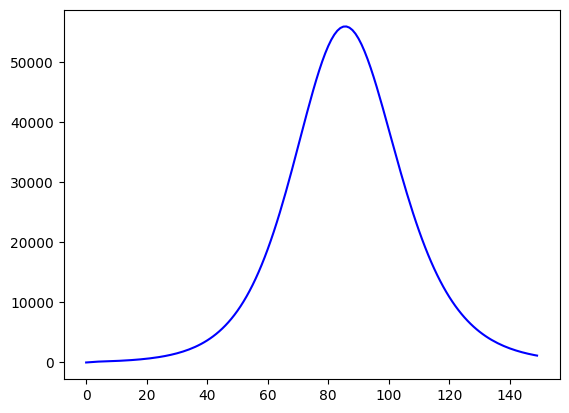

In [2]:
model = SEIRModel(population=5*1e6)
R_0 = 2

t_incubation = 2 # in days
t_infective = 4 # in days

alpha = 1/t_incubation
gamma = 1/t_infective
beta = gamma*R_0
init_inf_frac = 0.0001
init_rec_frac = 0.2
tmax = 150 # days

res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, init_inf_frac=init_inf_frac, init_rec_frac=init_rec_frac)

plt.plot(res.daily_incidence, color='blue', alpha=1)

In [ ]:
num_exp = 10
noise_data_arr = []
for index in range(num_exp):
    error_model = NaiveErrorModel(res.daily_incidence, mean_delay=11, mean_underreporting=0.5, error_mode='fixed')
    error_model.add_noise()
    noise_data_arr.append(error_model.incidence_arr)


fig, ax = plt.subplots(figsize=(8, 5))
# initial data
ax.plot(res.daily_incidence, color='RoyalBlue', lw=3, label='Initial SEIR')
ax.plot(noise_data_arr[0], '--o', color='OrangeRed', label='SEIR + noise', alpha=0.1)
for index in range(num_exp):
    ax.plot(noise_data_arr[index], '--o', color='OrangeRed', alpha=0.1)

mean_curve = np.nanmean(noise_data_arr, axis=0)
ax.plot(mean_curve, lw=3, color='ForestGreen', label='Mean curve')
ax.set_xlabel('Day')
ax.set_ylabel('Incidence, cases')
ax.legend()
ax.set_title(r'{} experiments'.format(num_exp))
ax.grid()
# fig.savefig('./figures/report_rscf_seir_only_noise.pdf', bbox_inches='tight')
# fig.savefig('./figures/report_rscf_seir_only_noise.png', dpi=600, 
#             bbox_inches='tight')

In [ ]:
true_params = model.last_sim_params

In [ ]:
estimated_params, r2_estimated = model.calibrate(res.daily_incidence)
# estimated_params = model.last_sim_params

In [ ]:
r2_estimated

In [ ]:
sim = model.simulate(*estimated_params.as_list(), tmax=150)
plt.plot(sim.daily_incidence, lw=3)
plt.plot(res.daily_incidence, '--o')

In [ ]:
model.calculate_rel_error(true_params, estimated_params)

In [ ]:
true_params()
estimated_params()

  8%|▊         | 1/13 [02:45<33:05, 165.42s/it]C:\Users\user\AppData\Local\Temp\ipykernel_4052\1782659691.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(10, 10))
 38%|███▊      | 5/13 [15:07<24:11, 181.48s/it]


KeyboardInterrupt: 

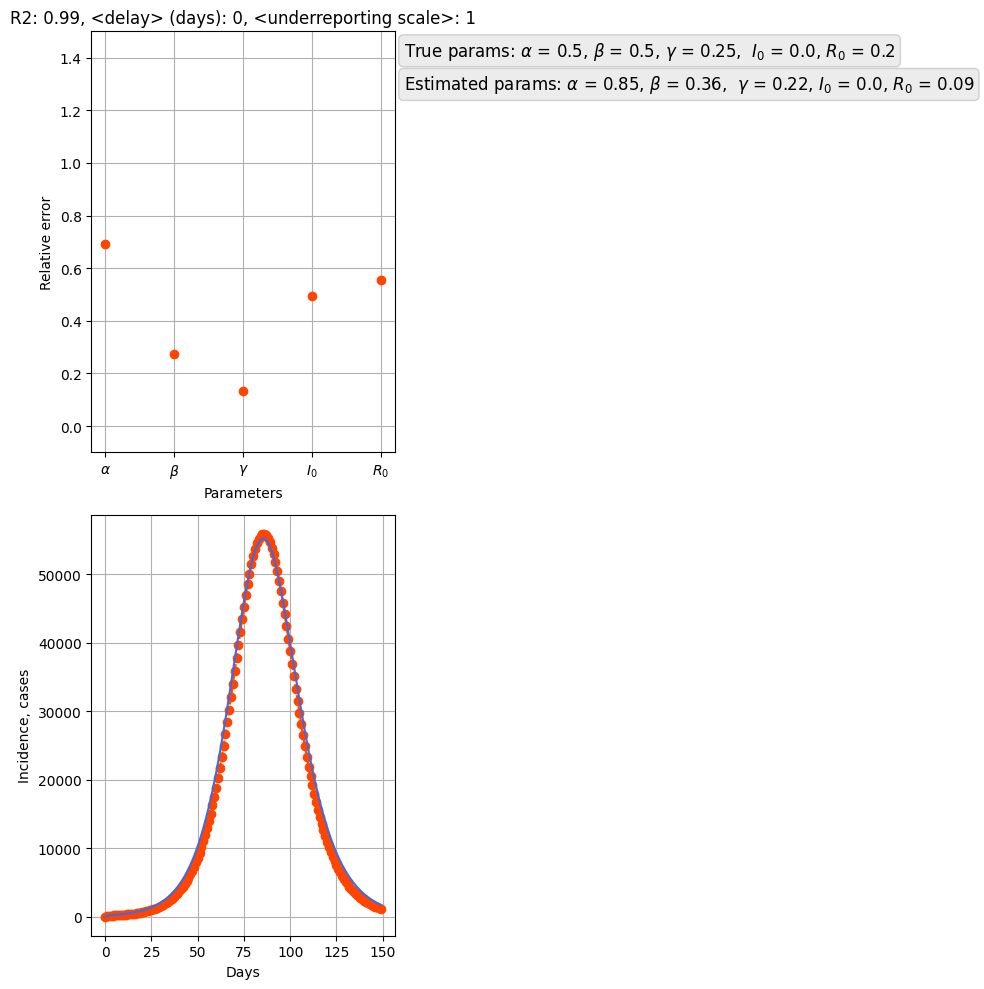

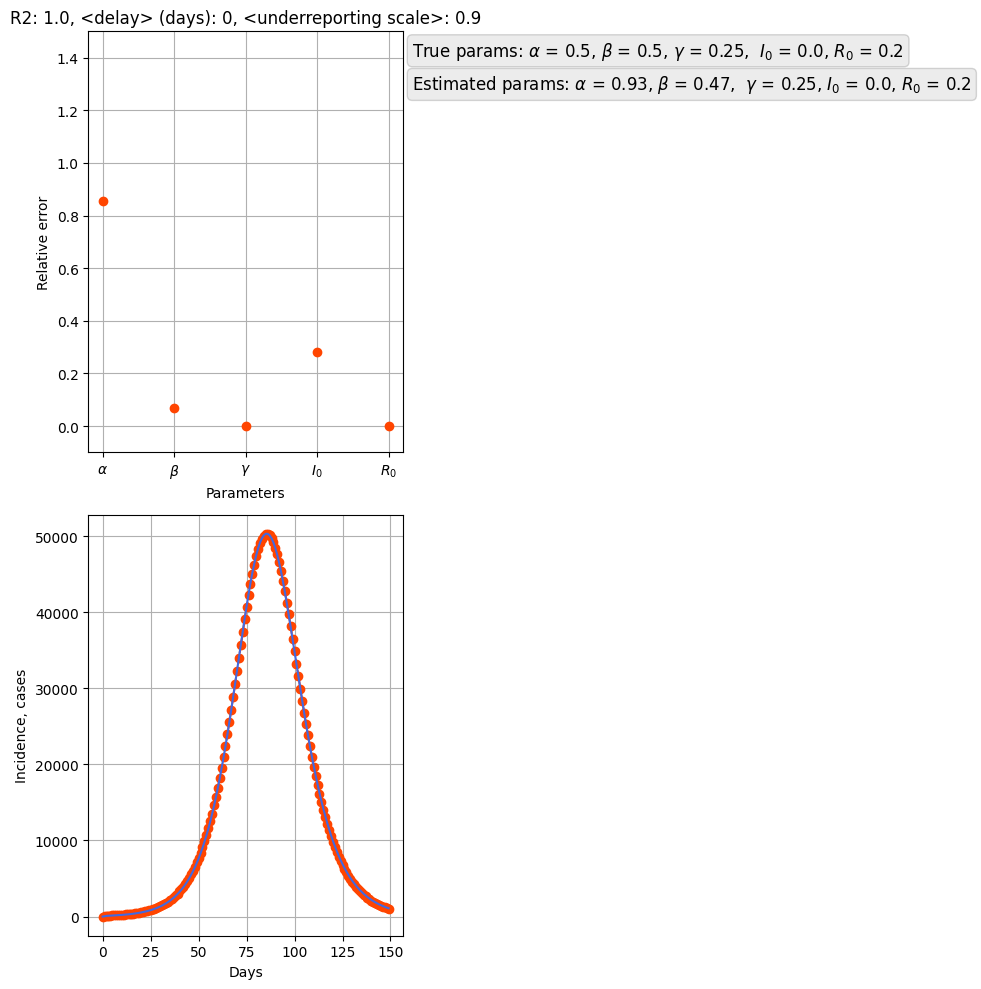

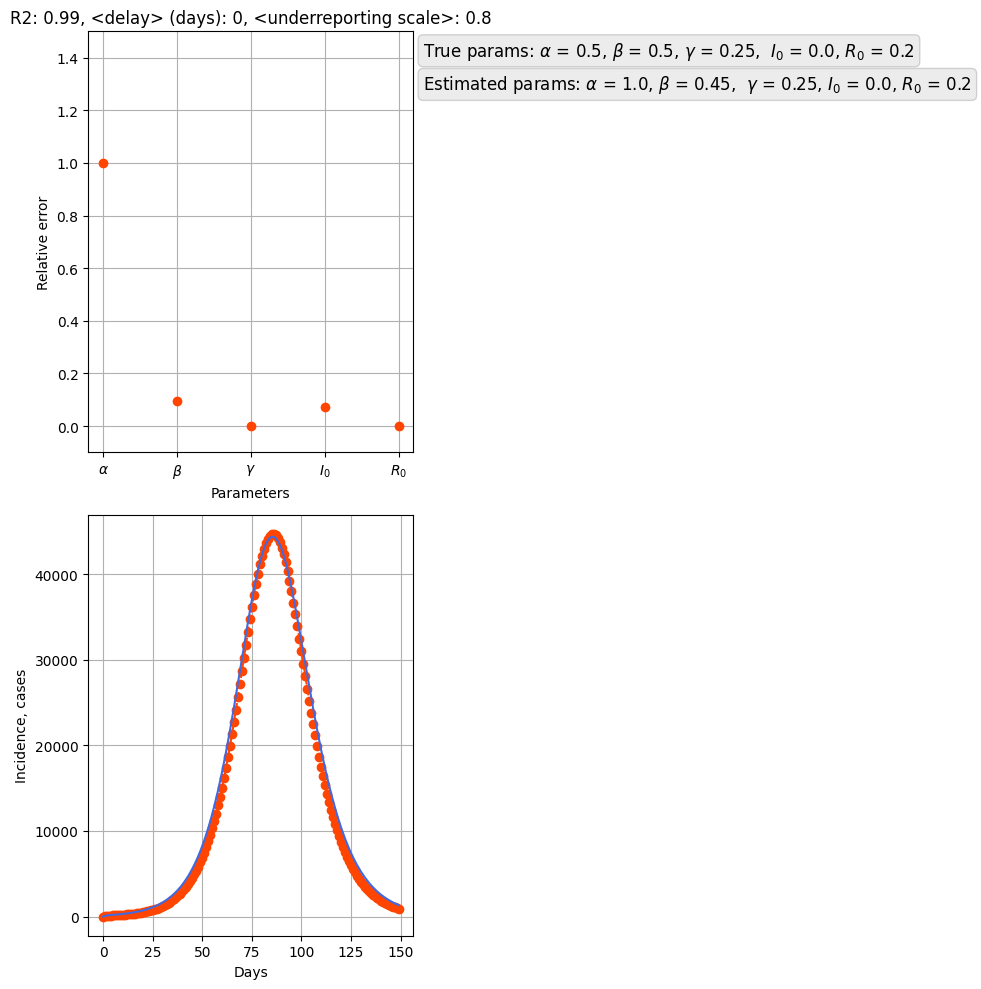

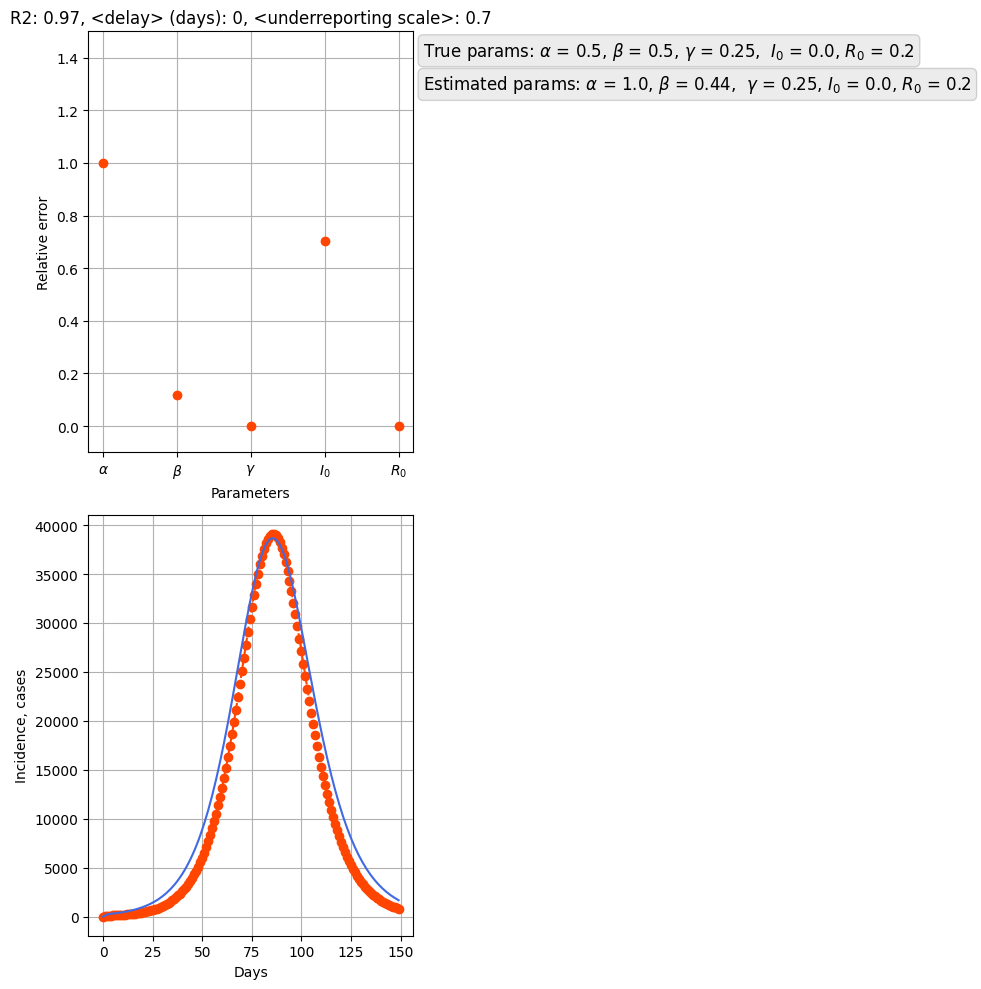

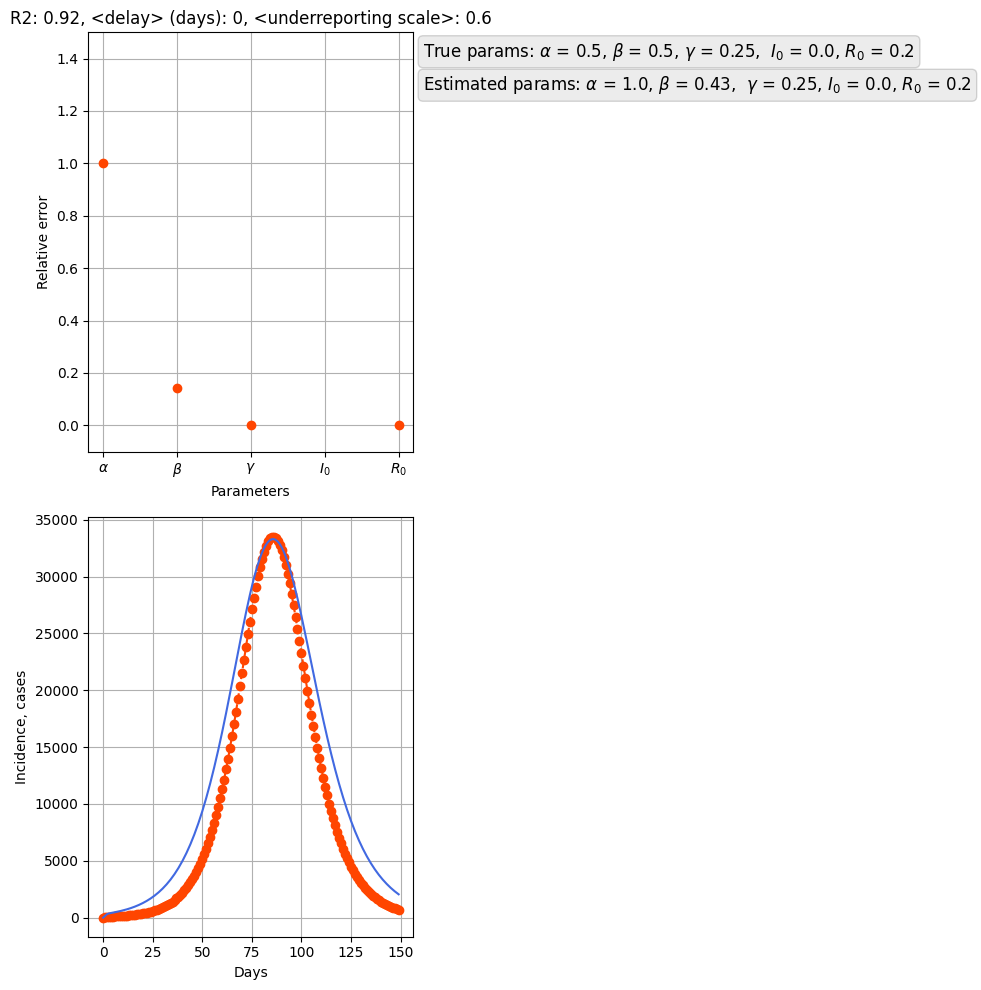

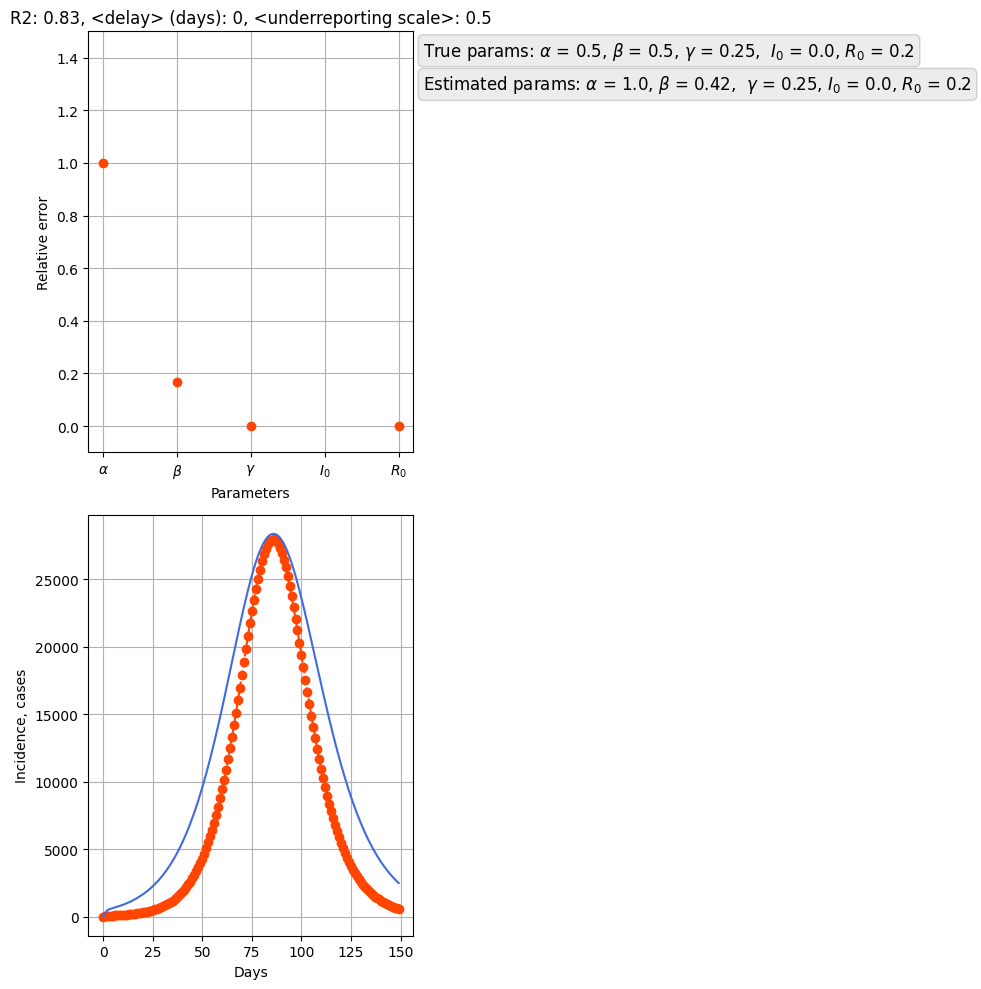

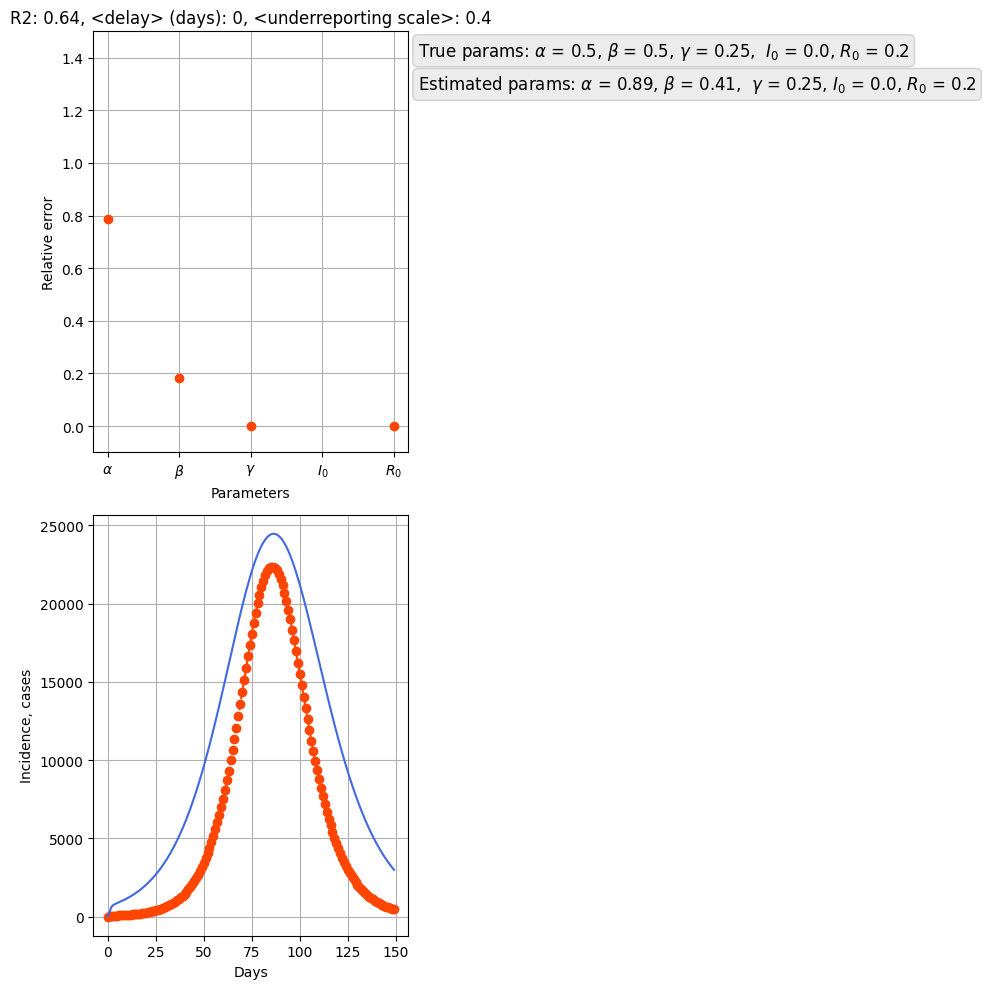

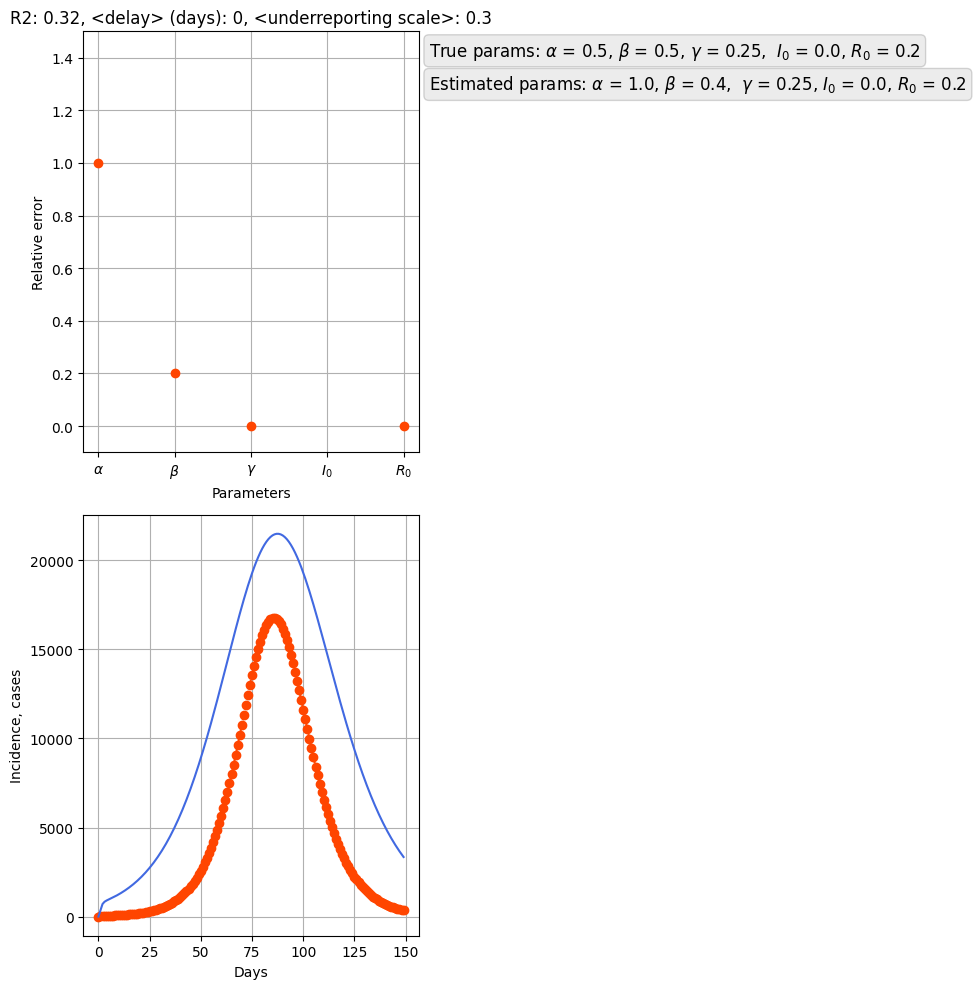

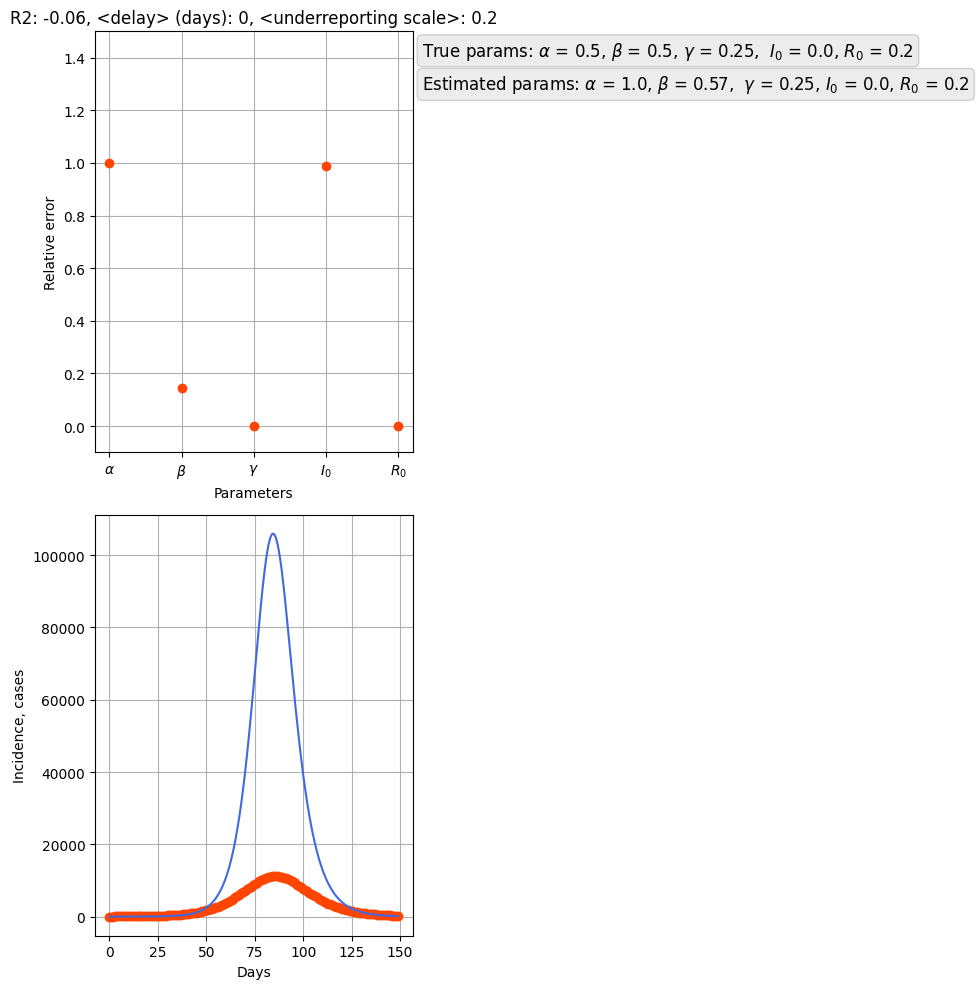

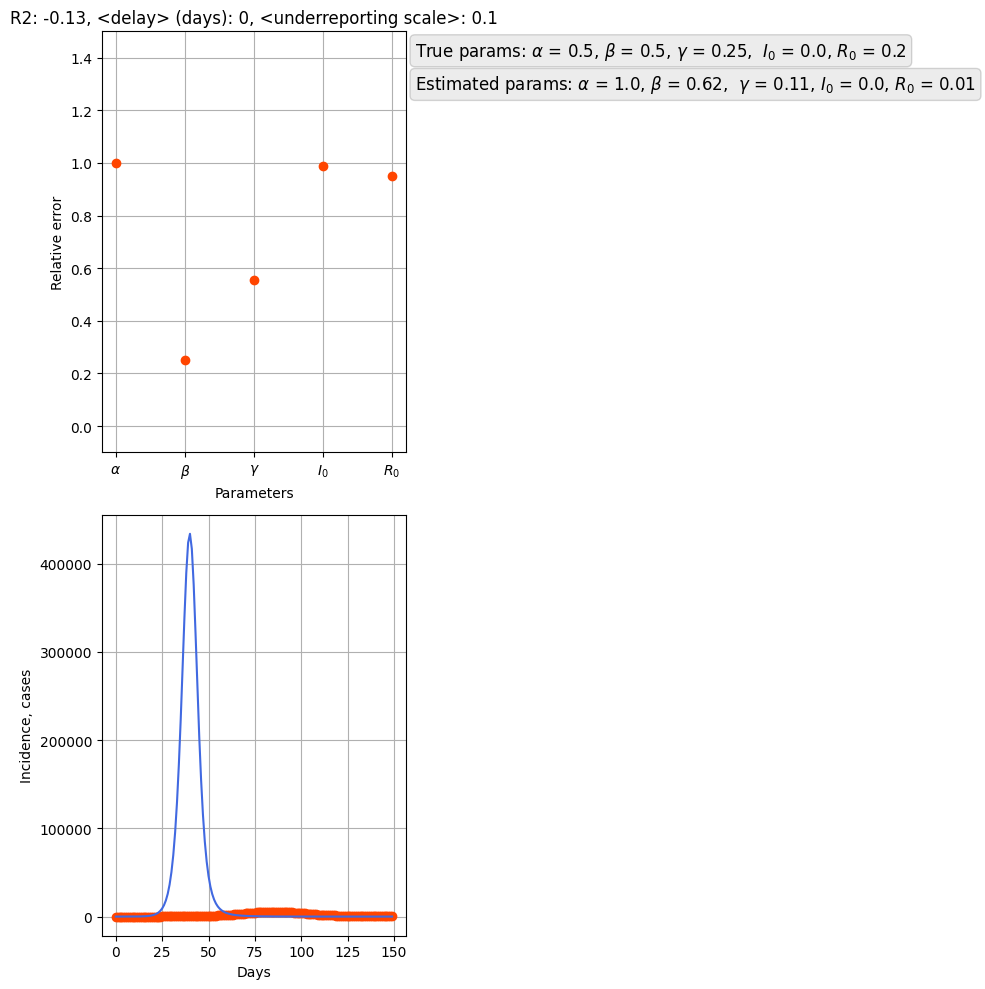

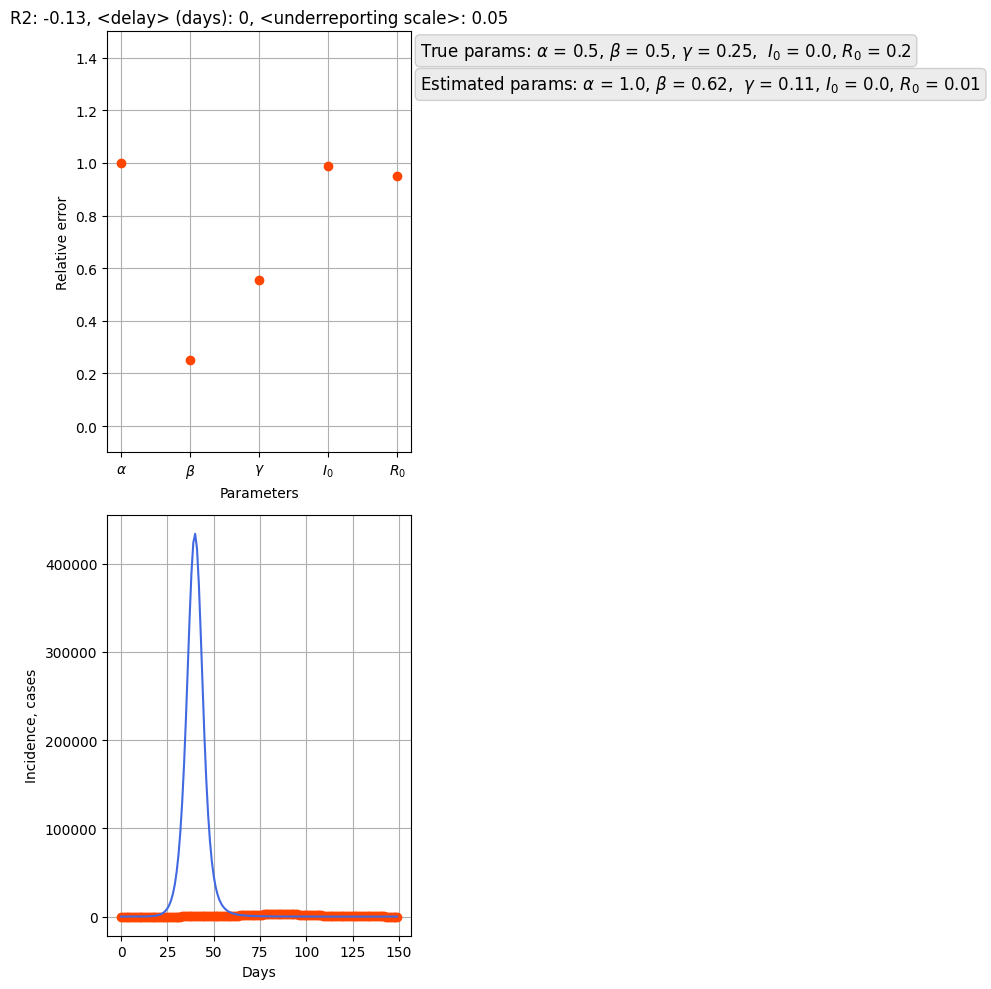

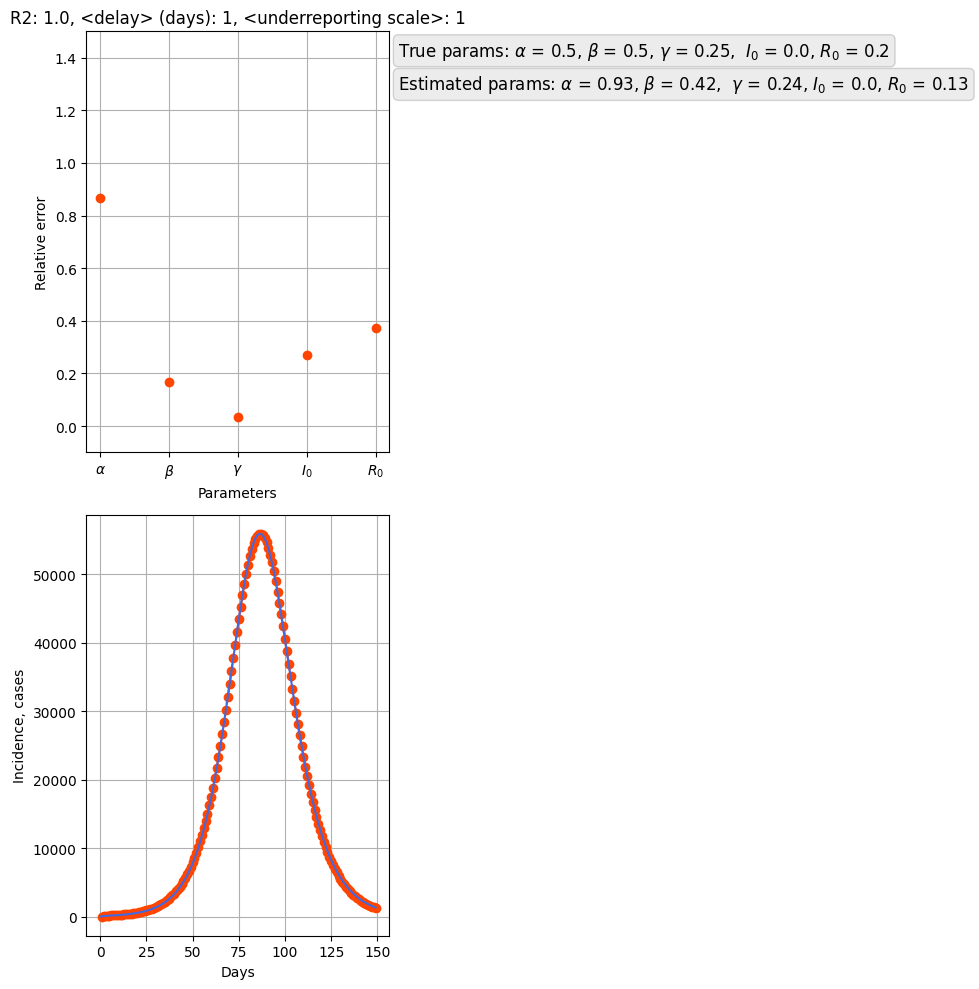

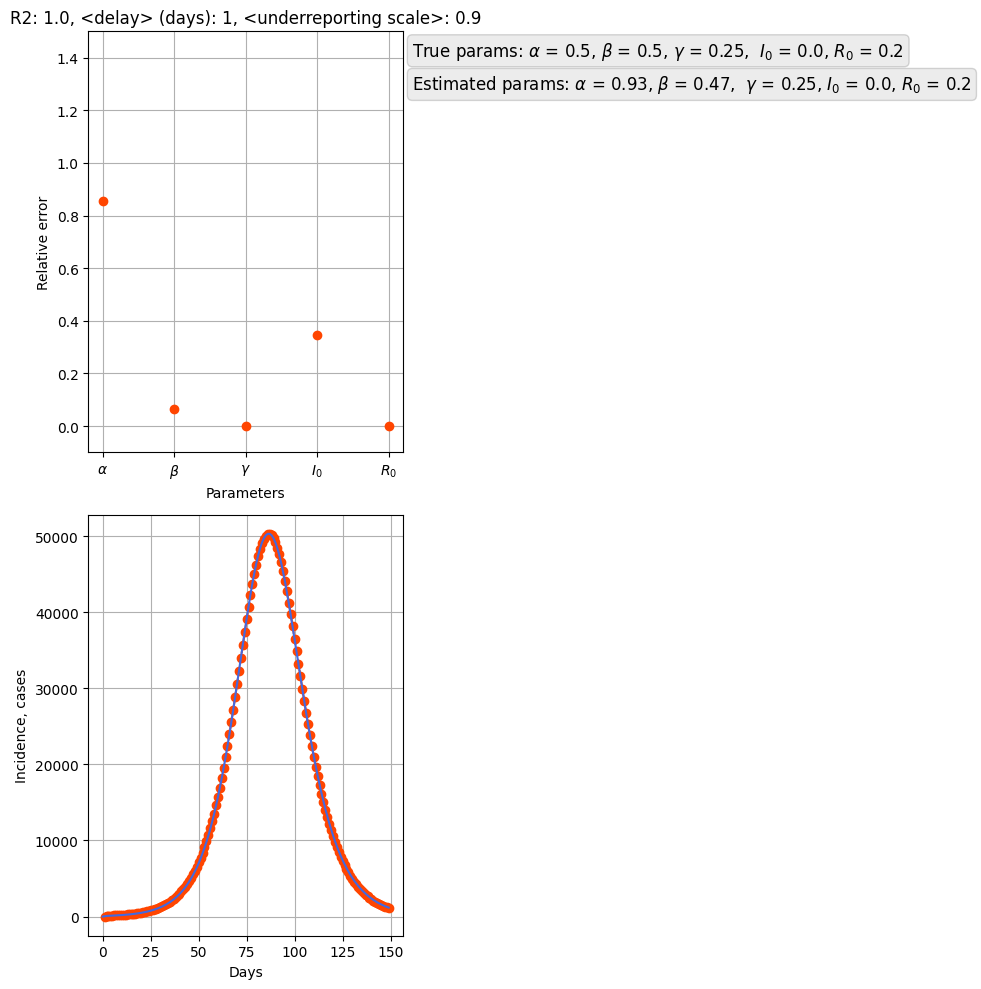

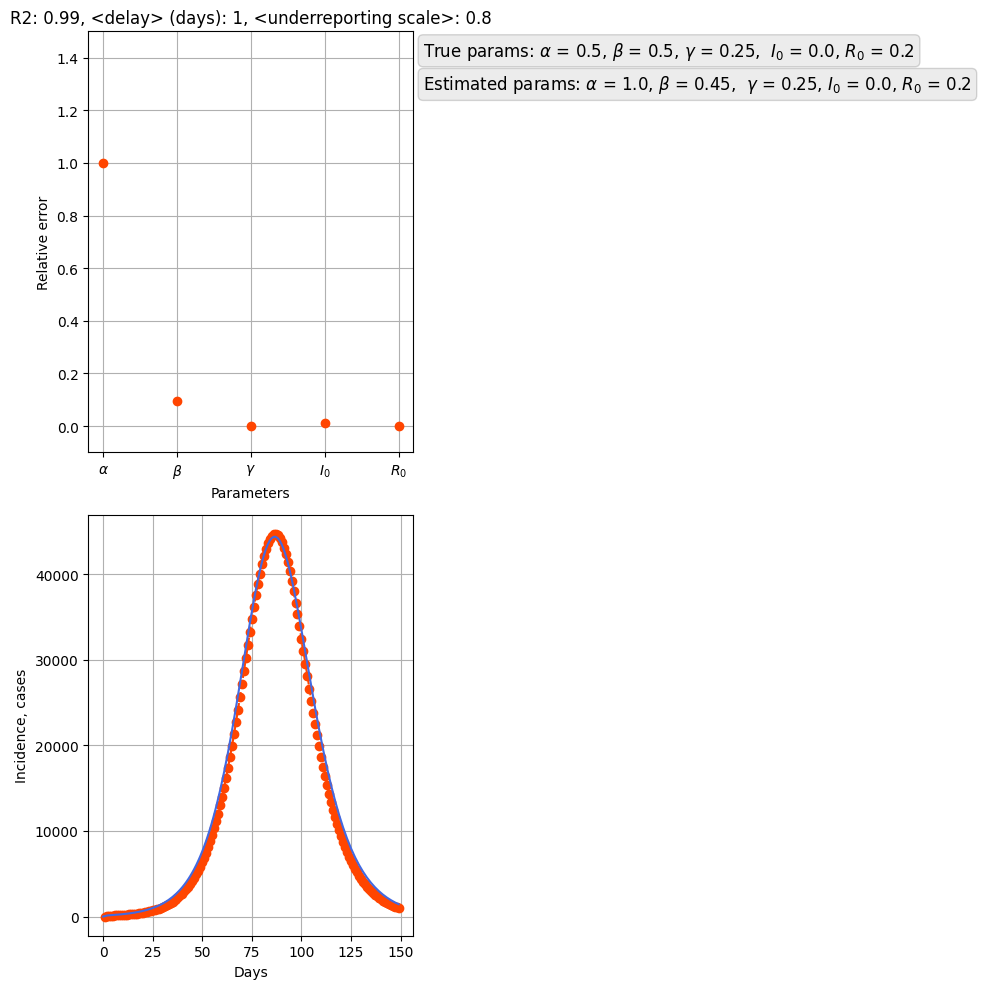

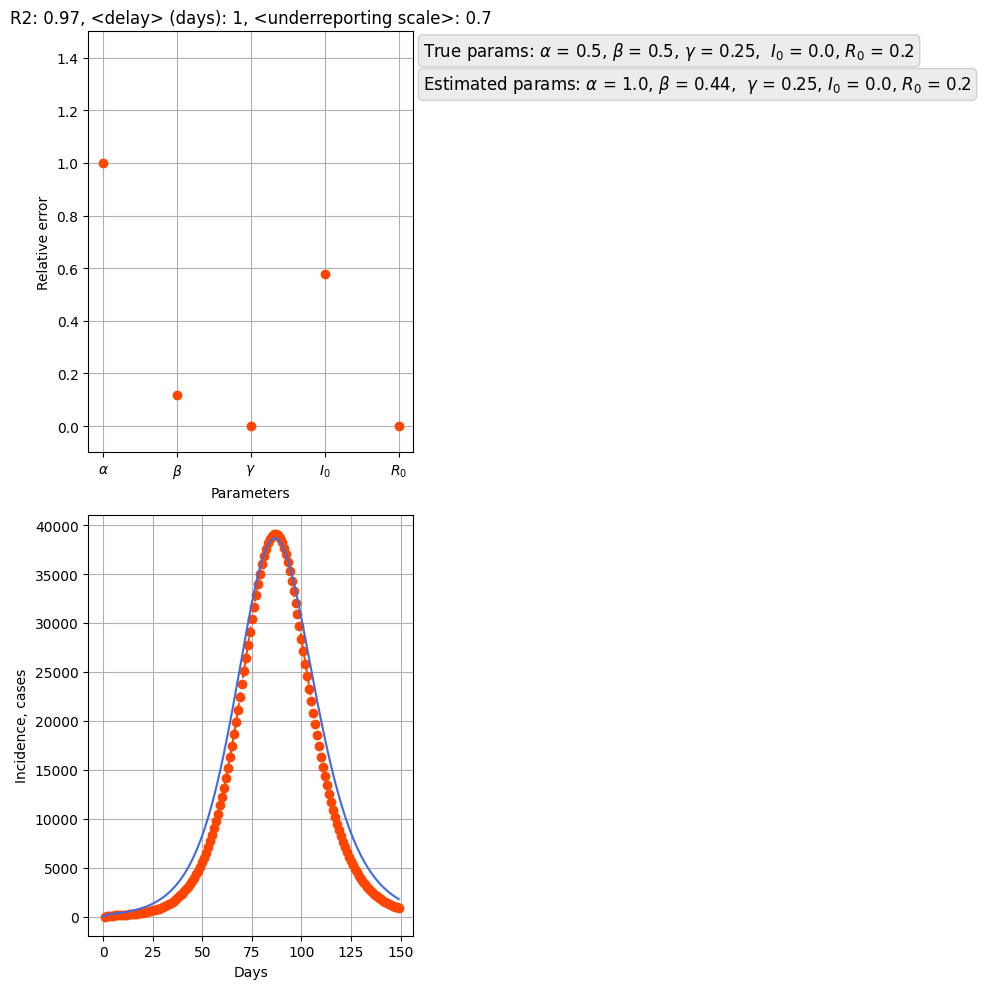

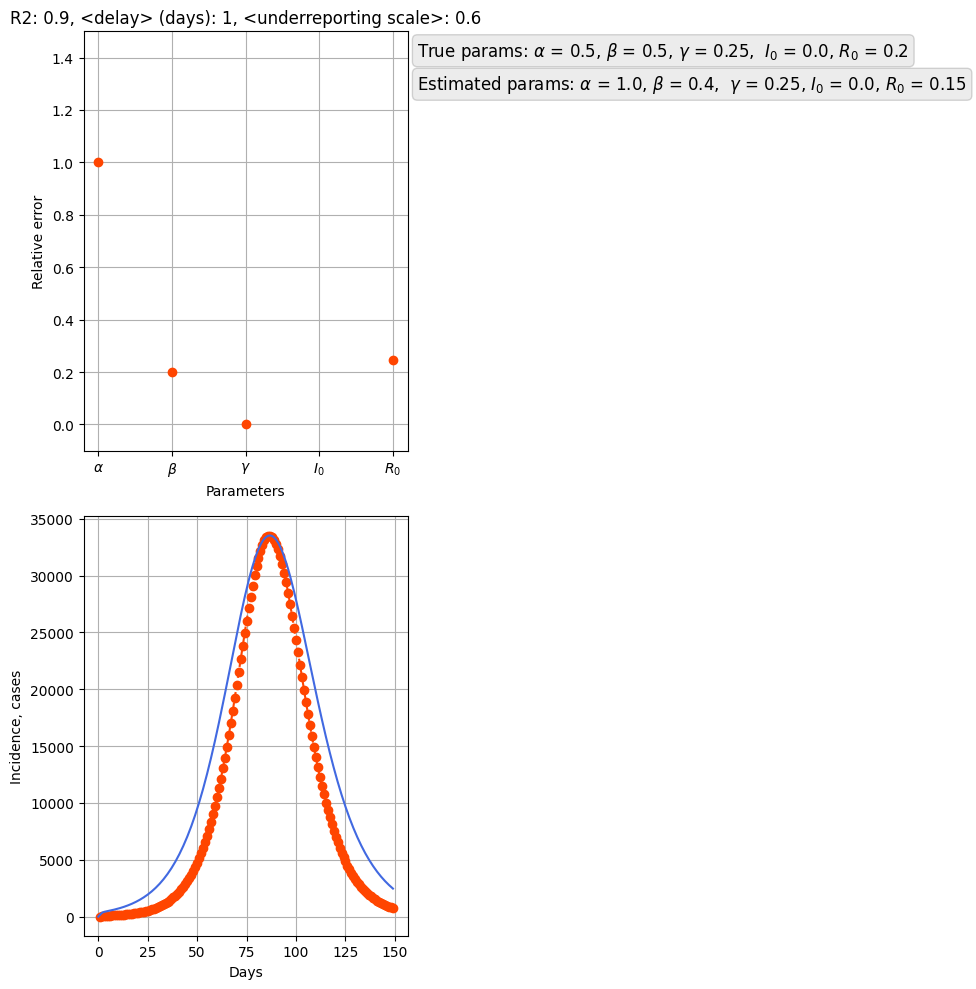

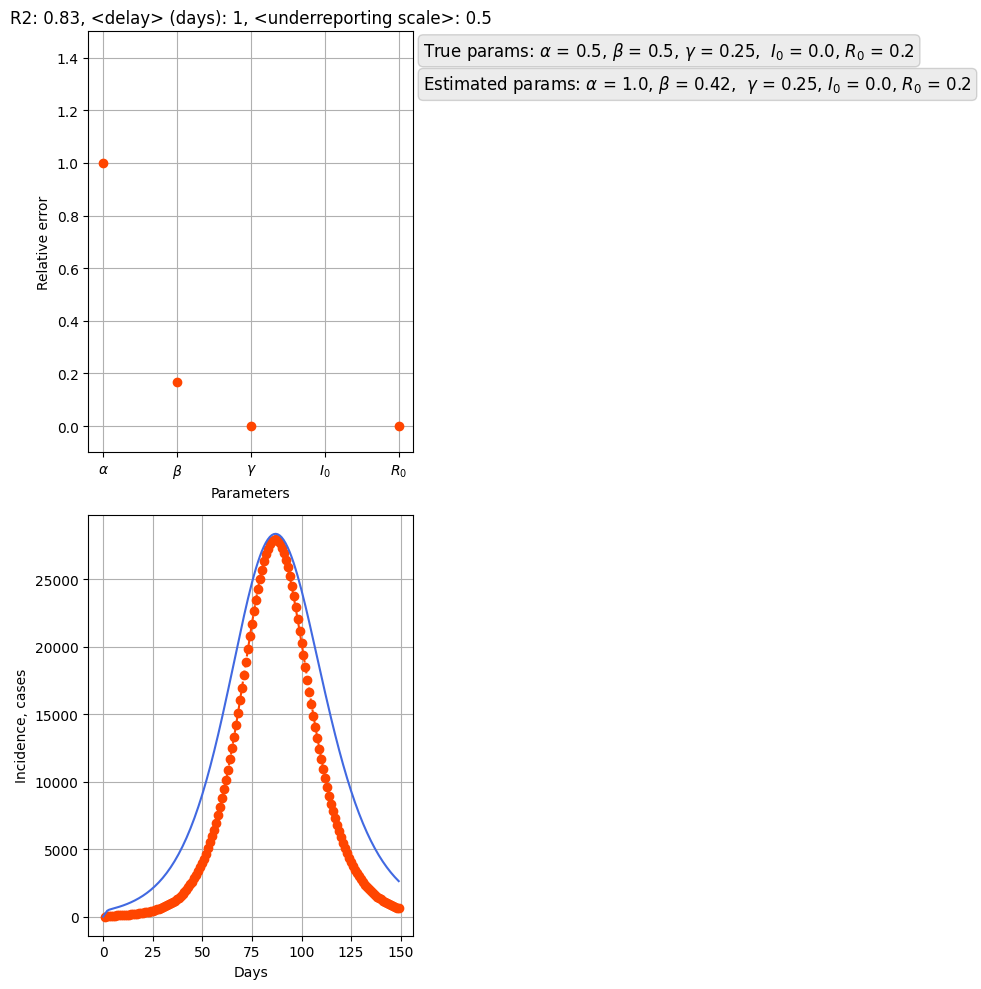

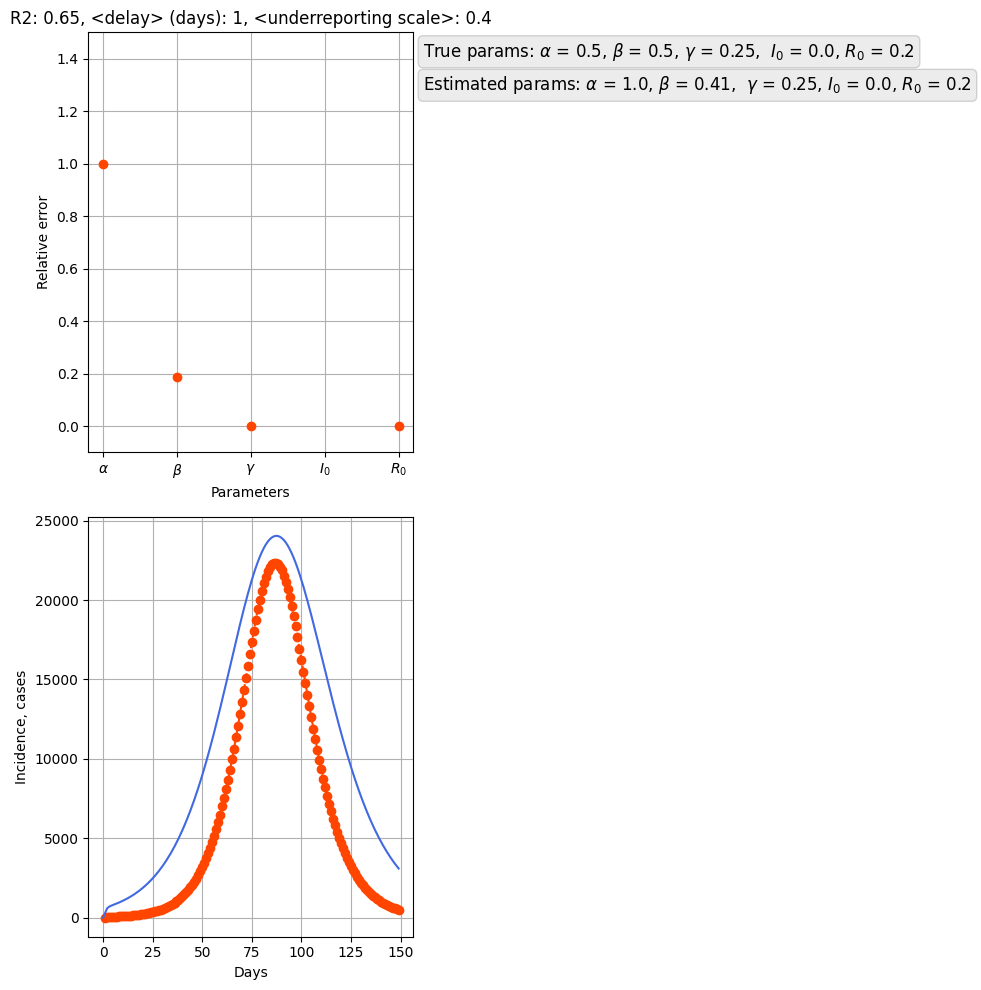

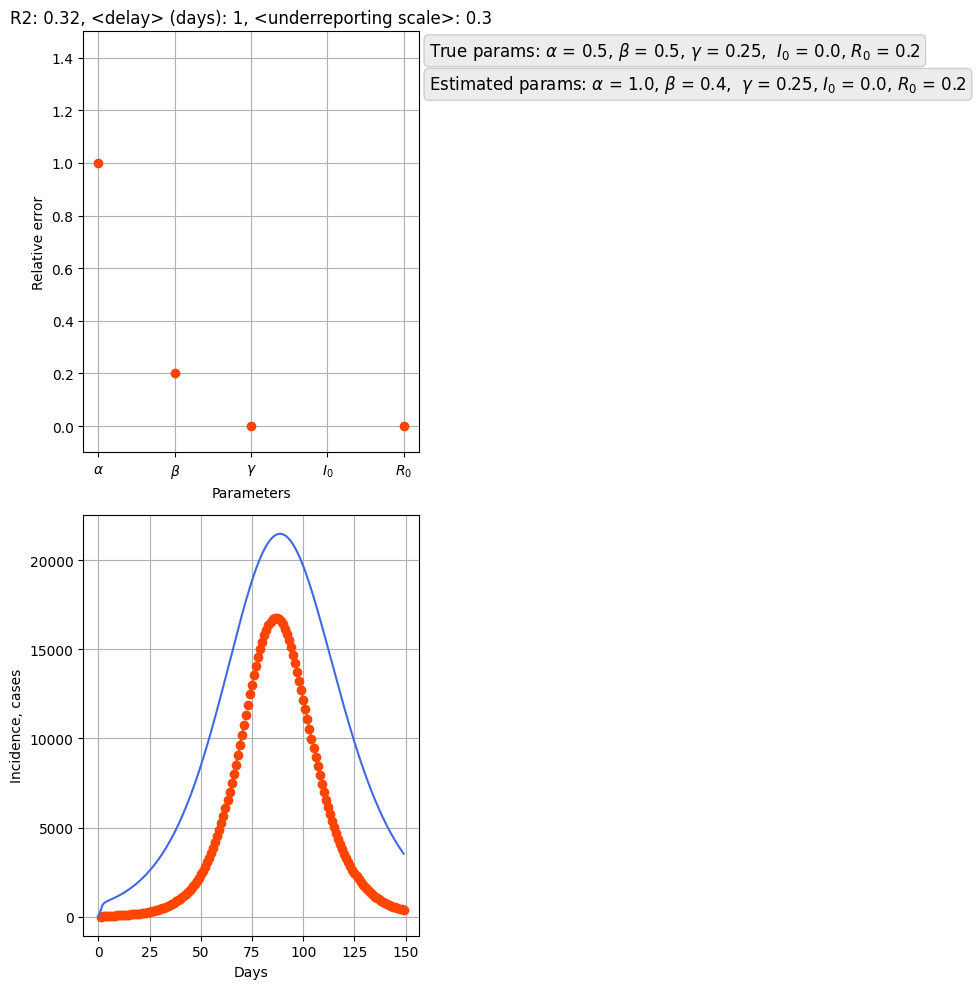

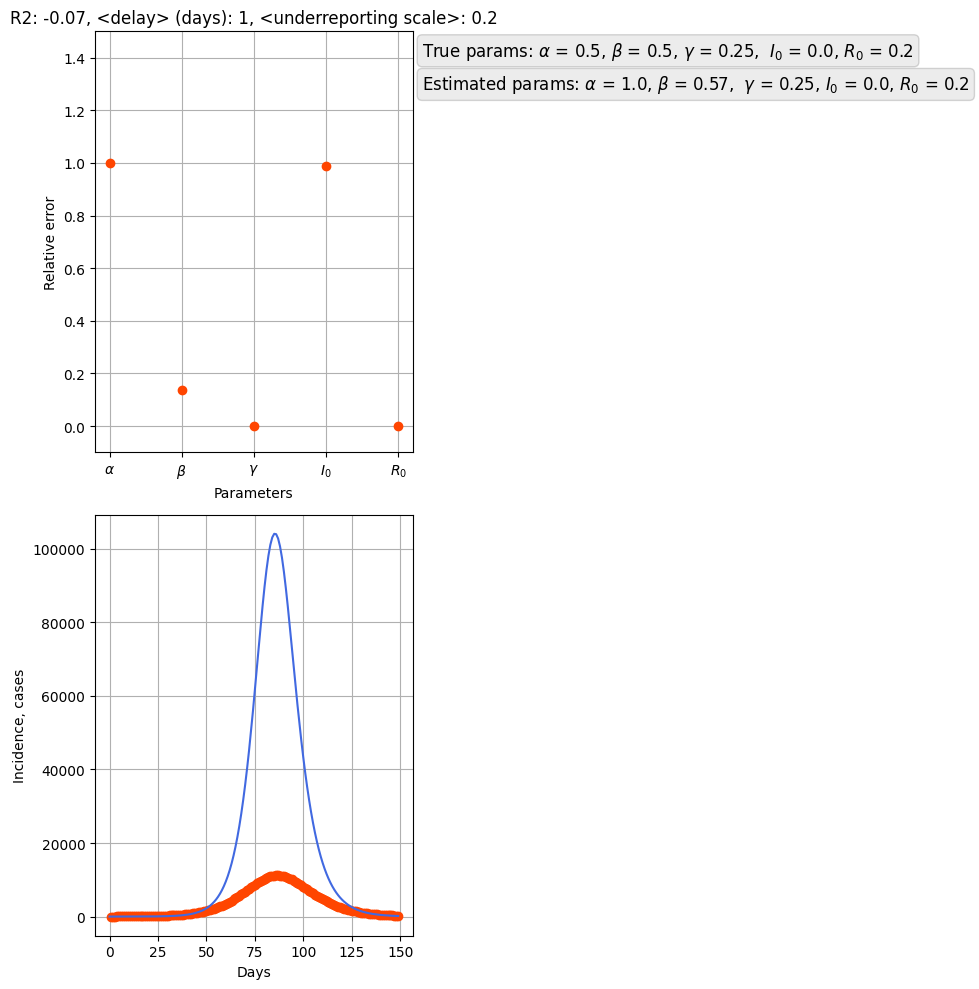

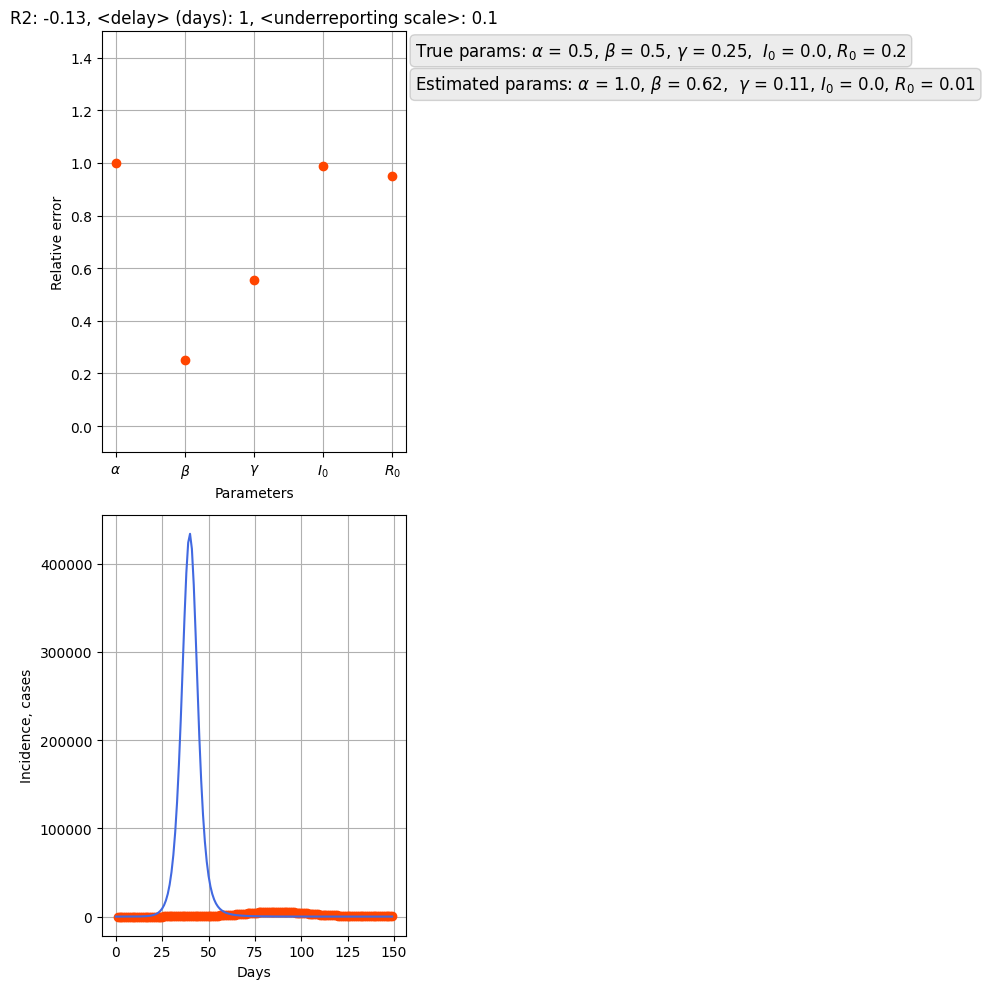

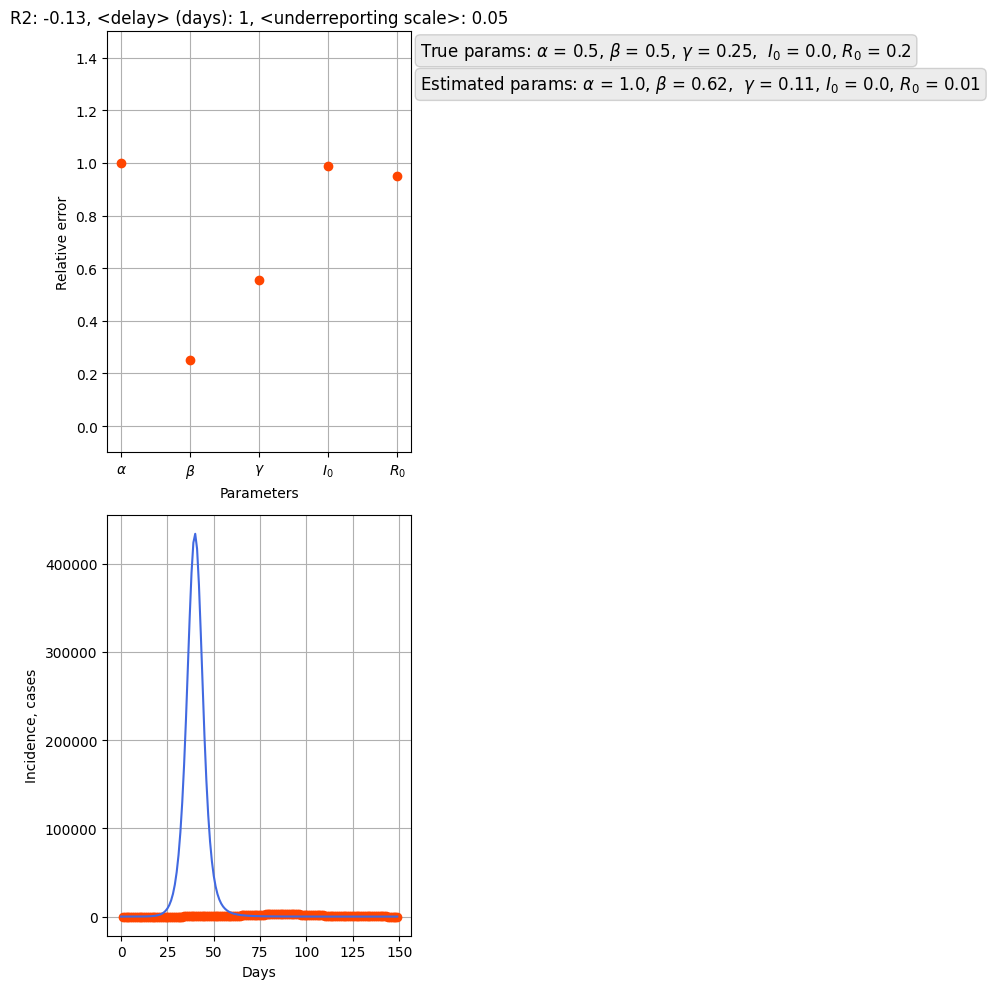

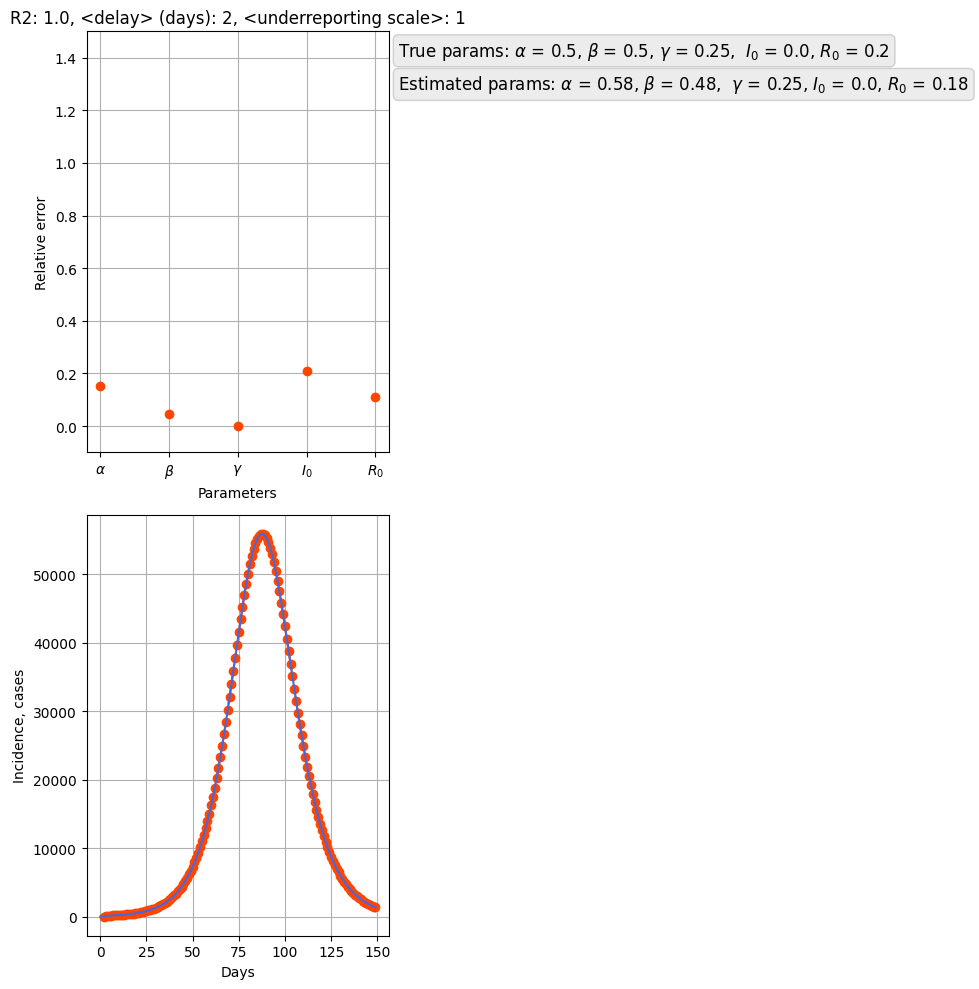

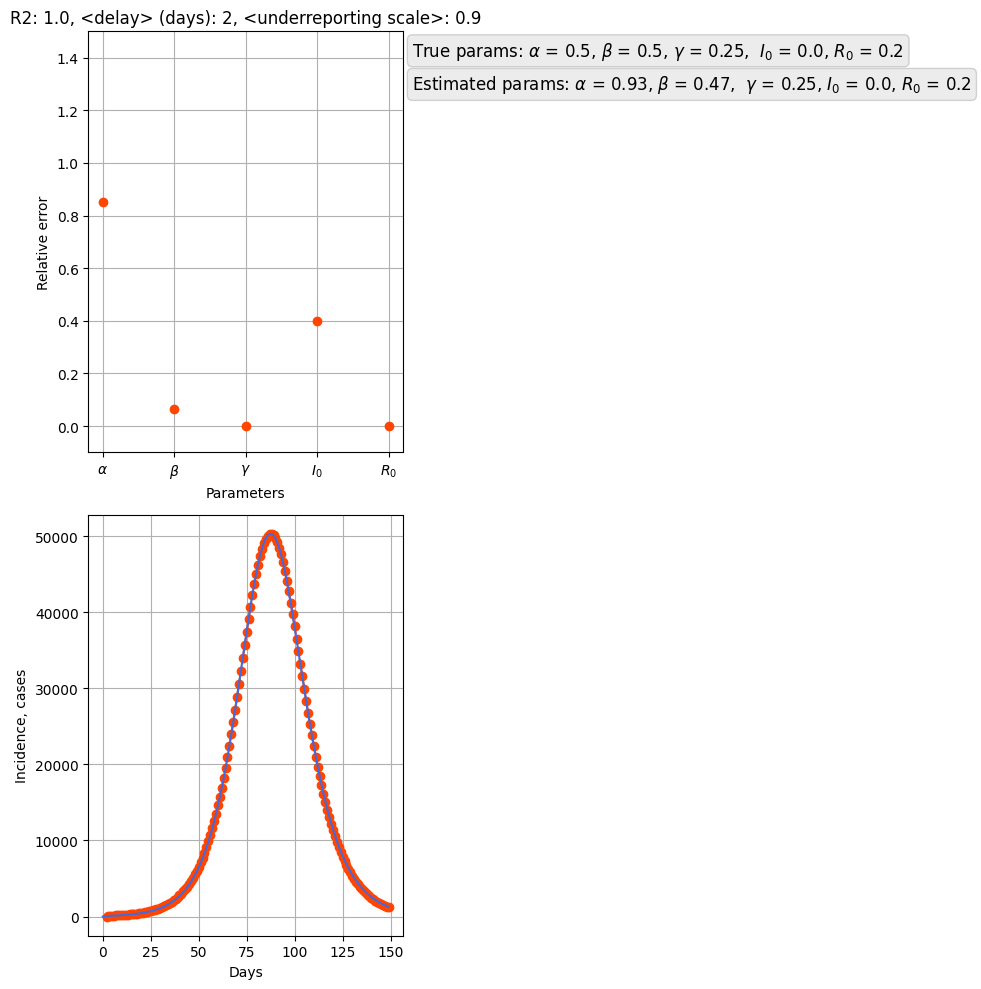

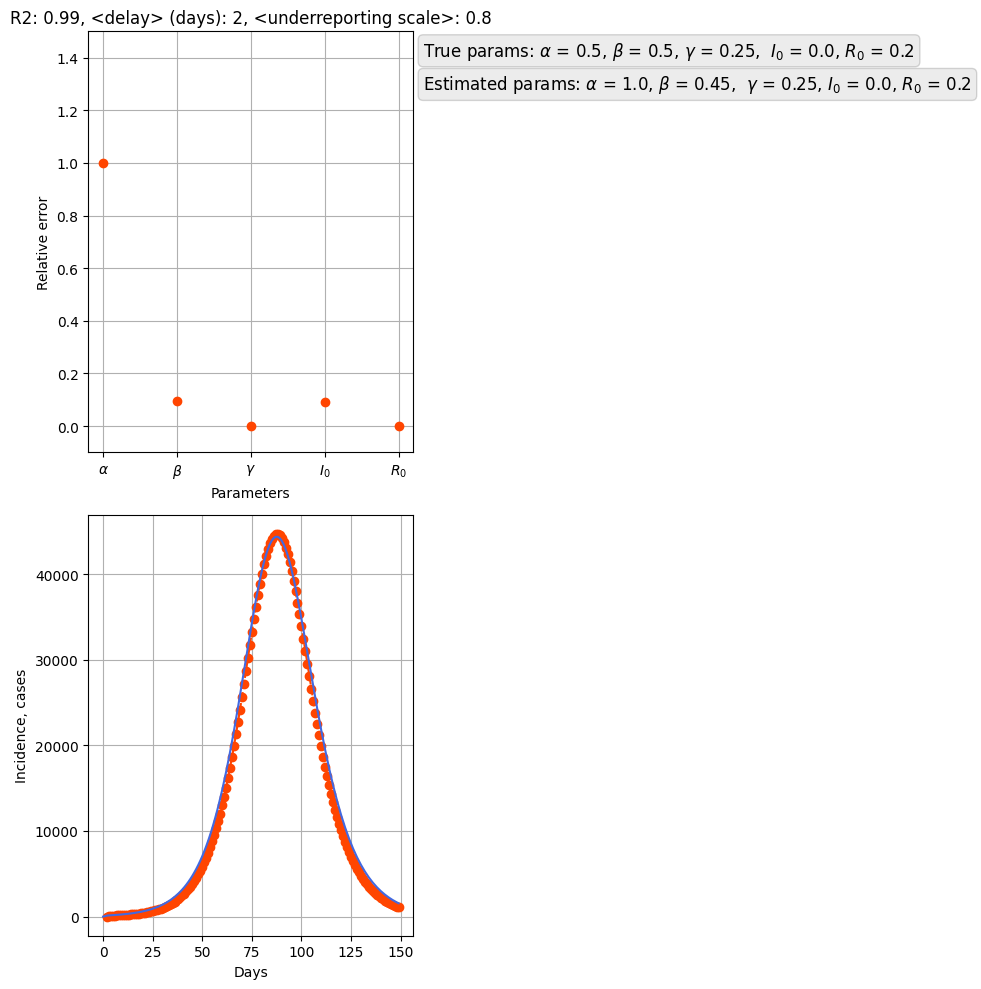

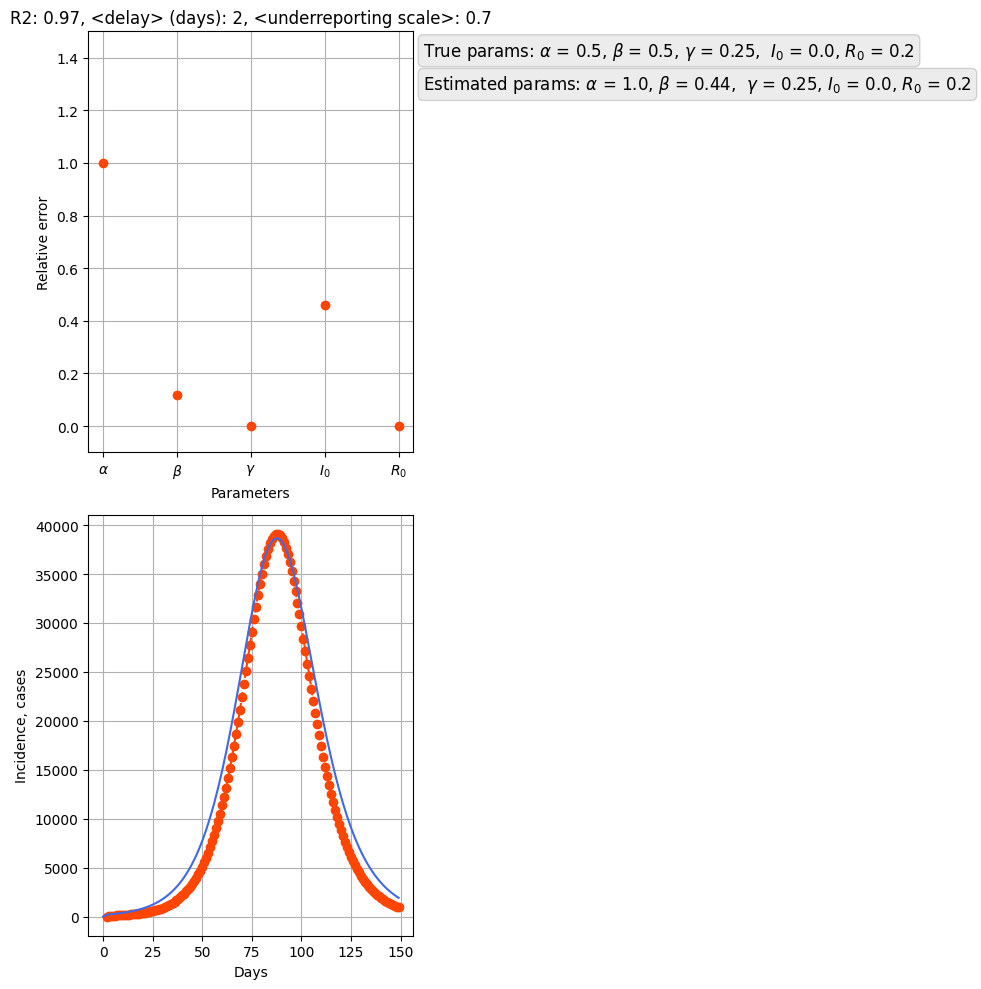

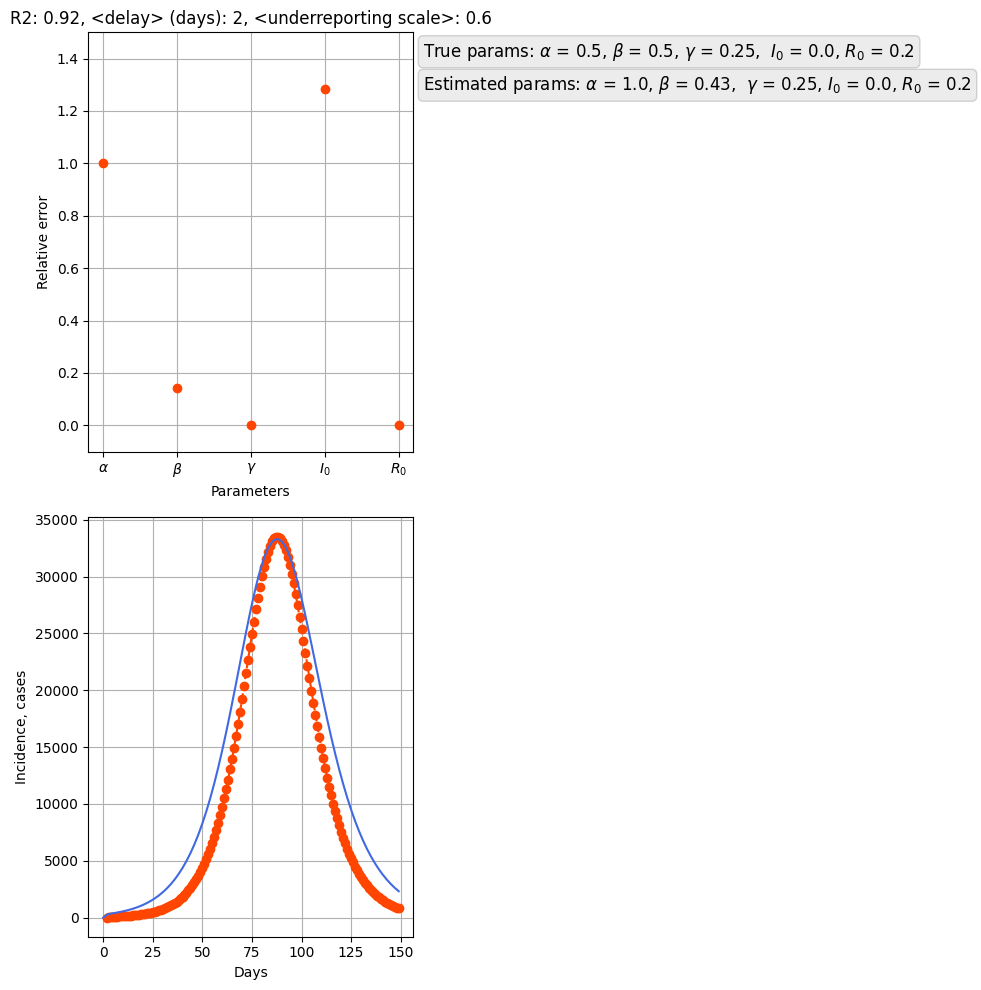

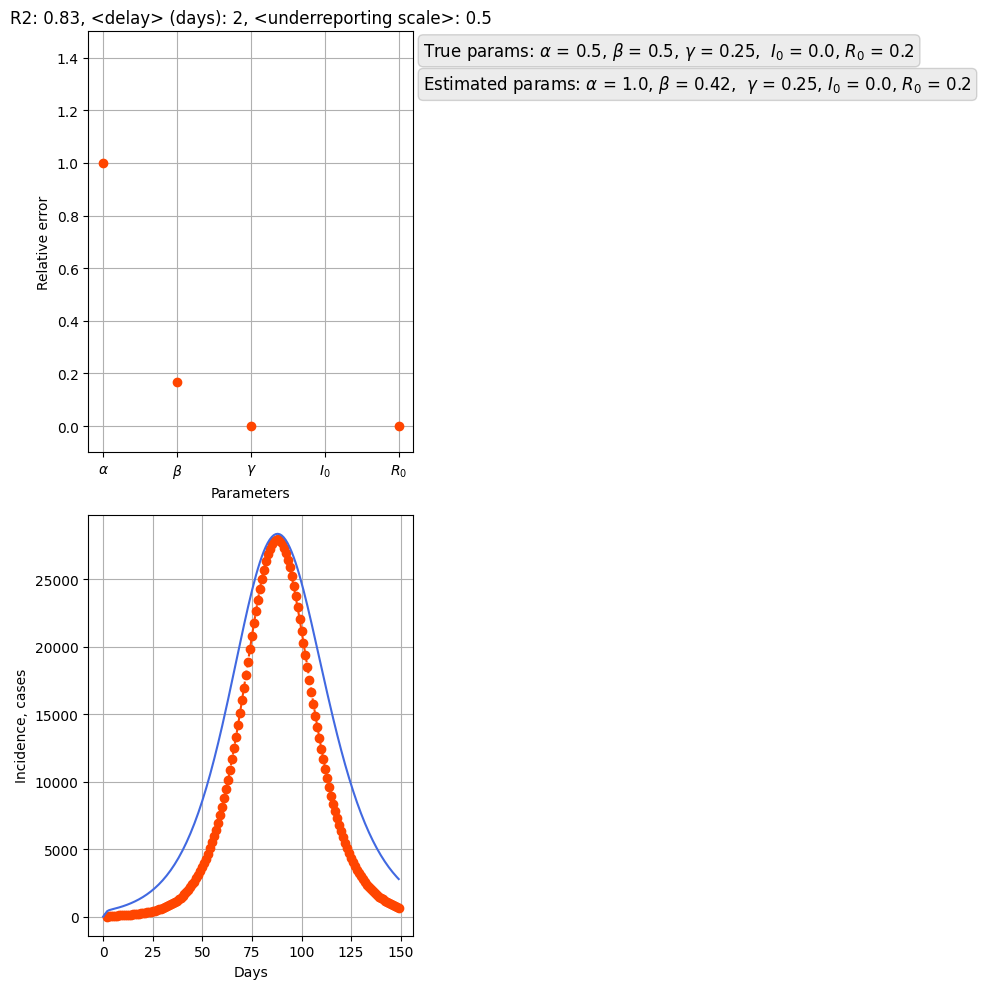

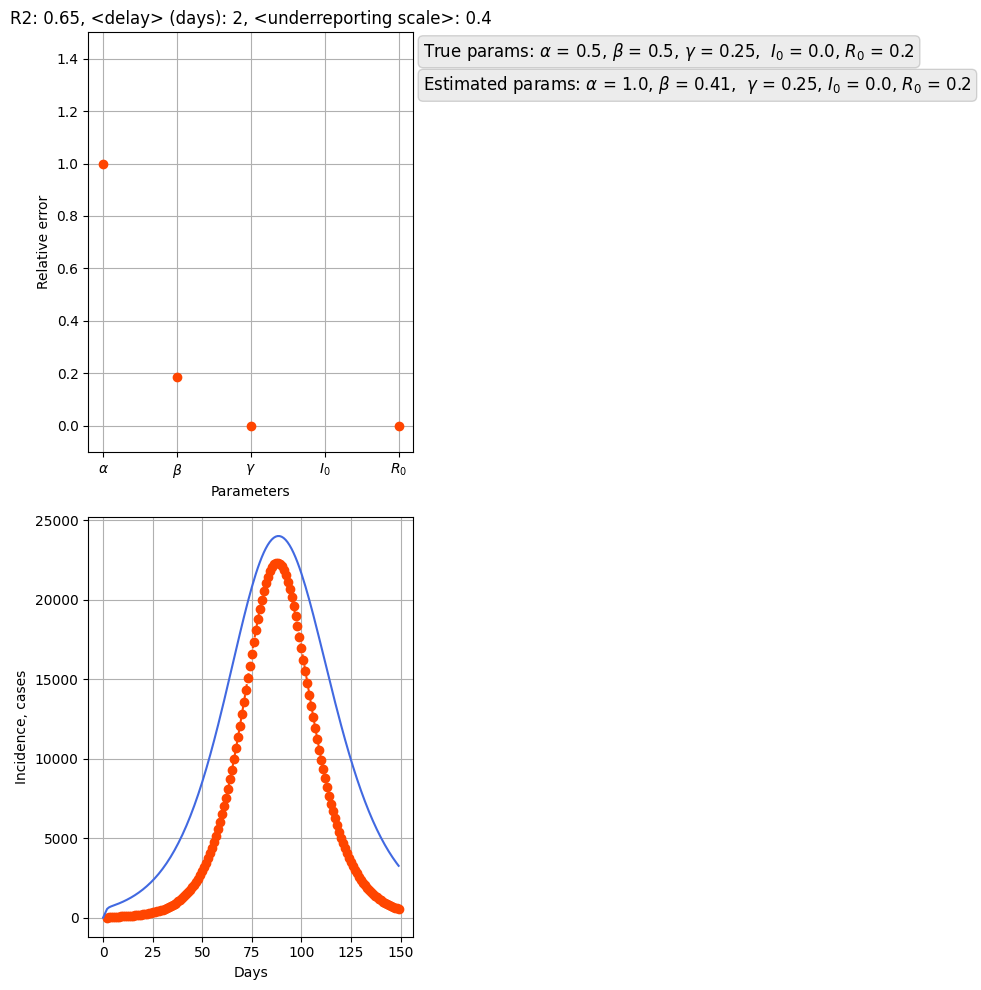

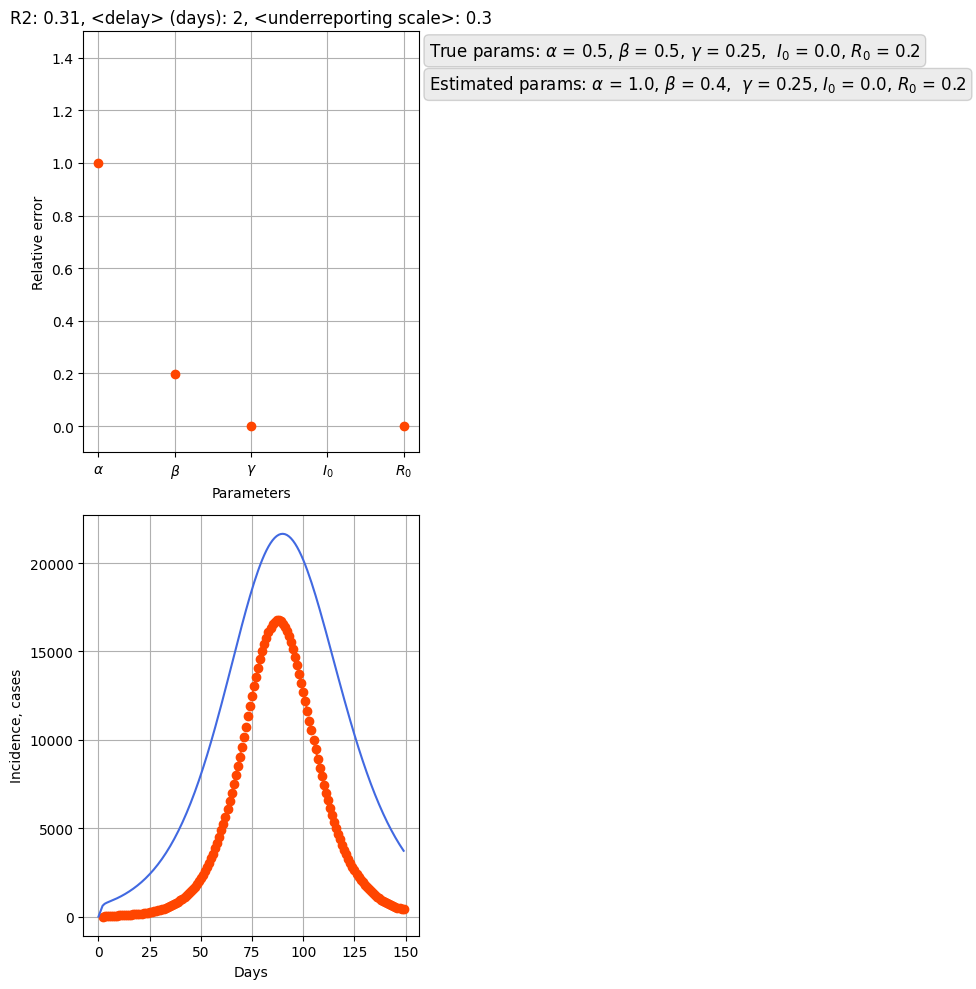

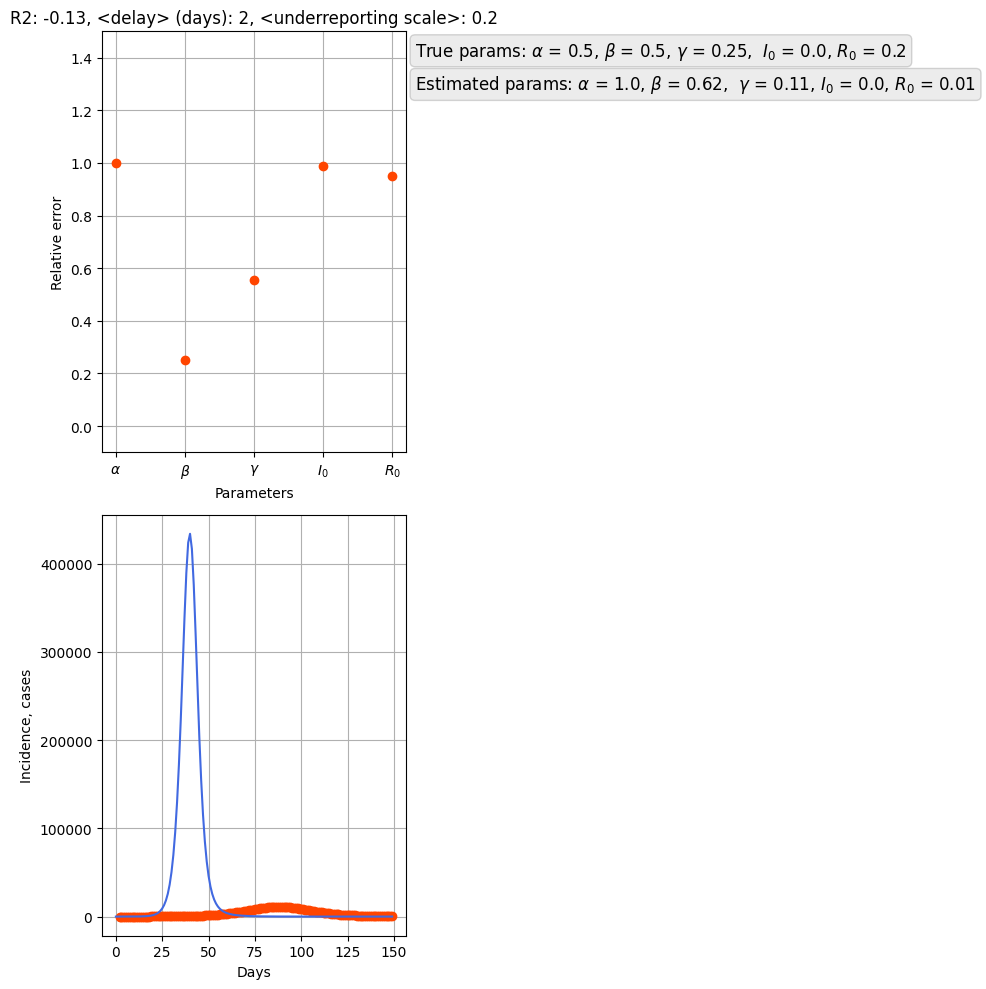

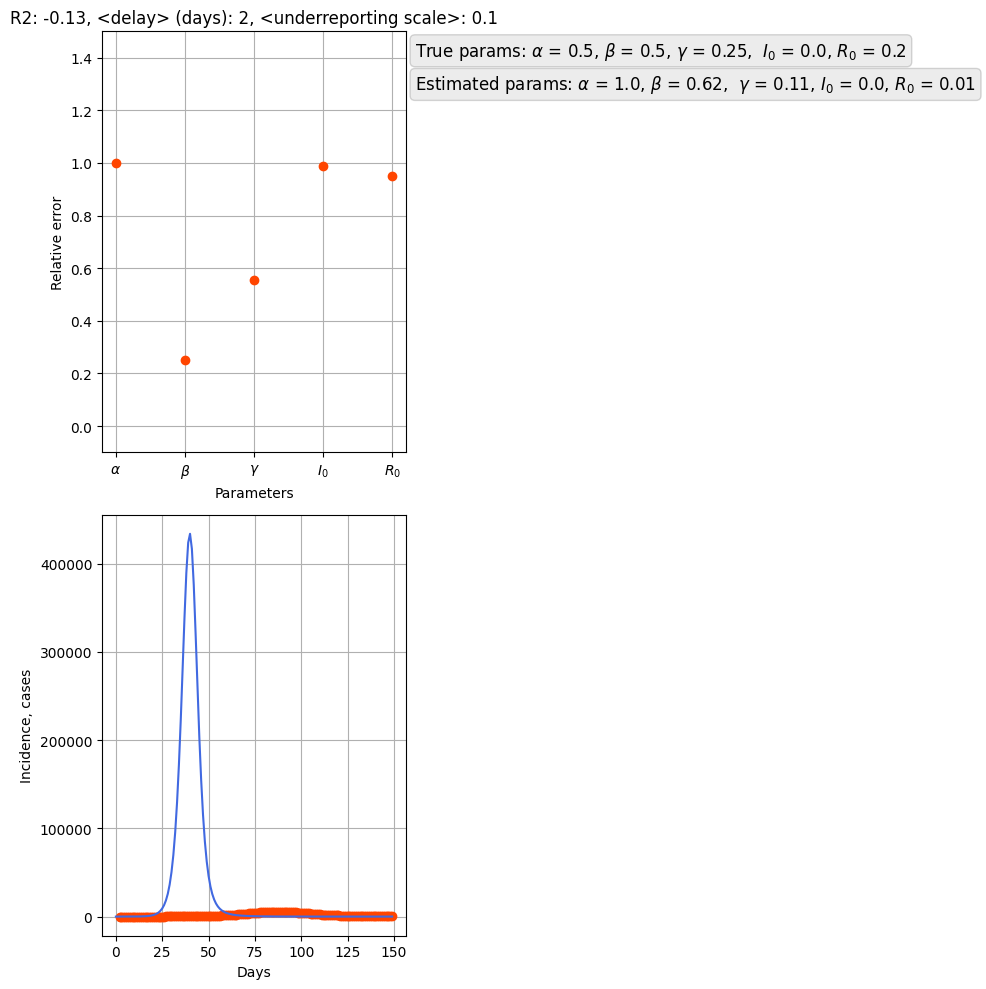

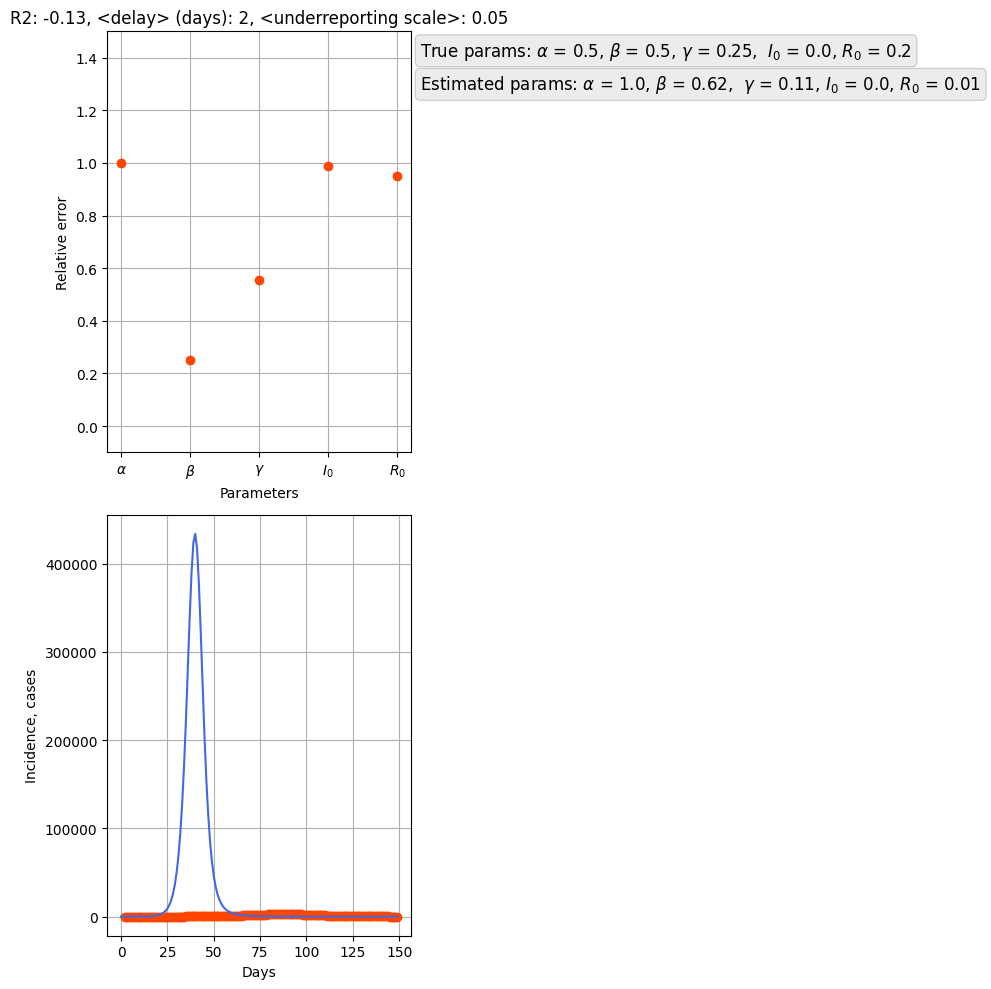

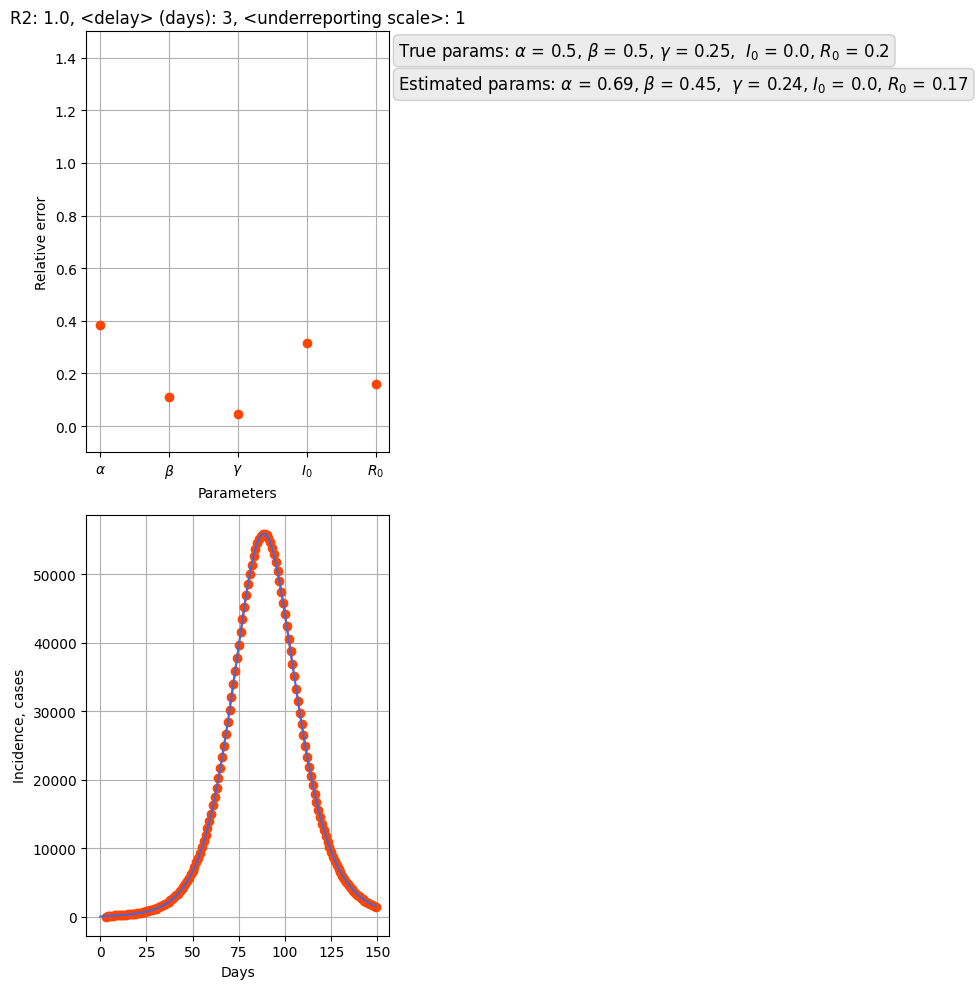

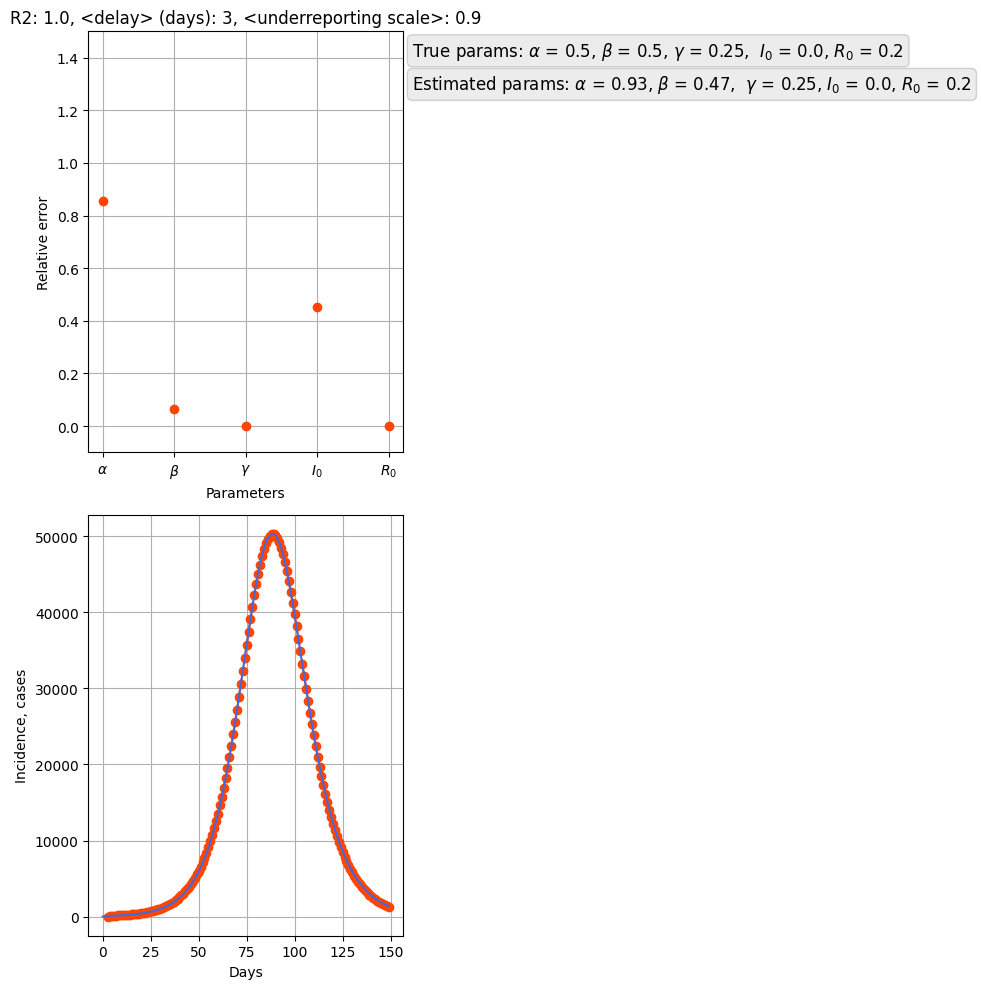

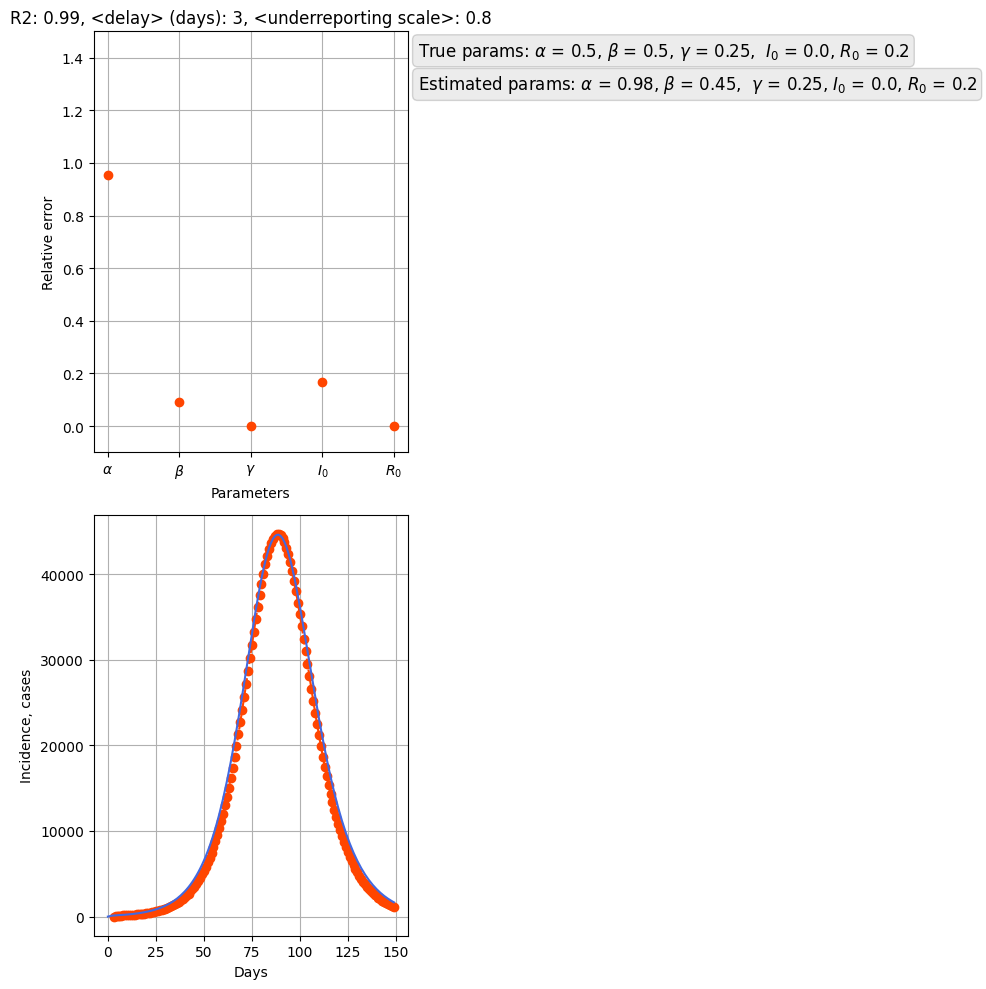

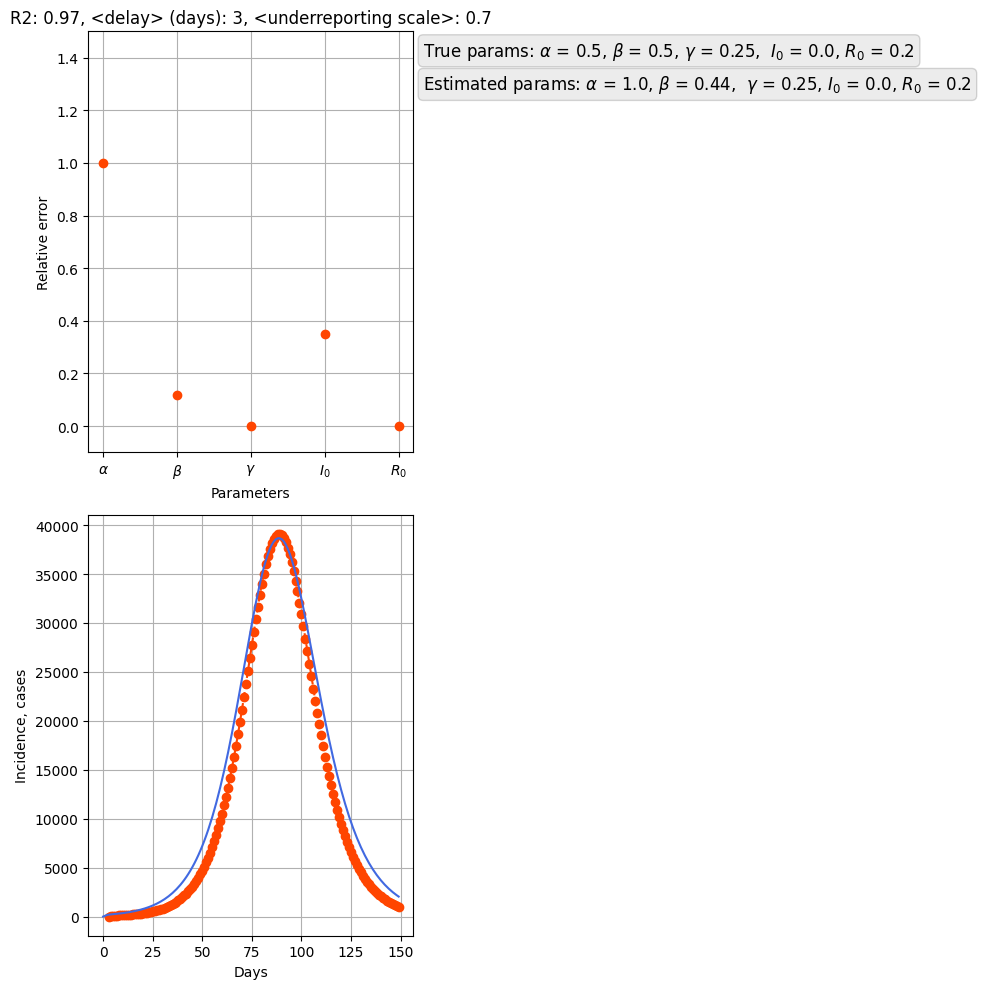

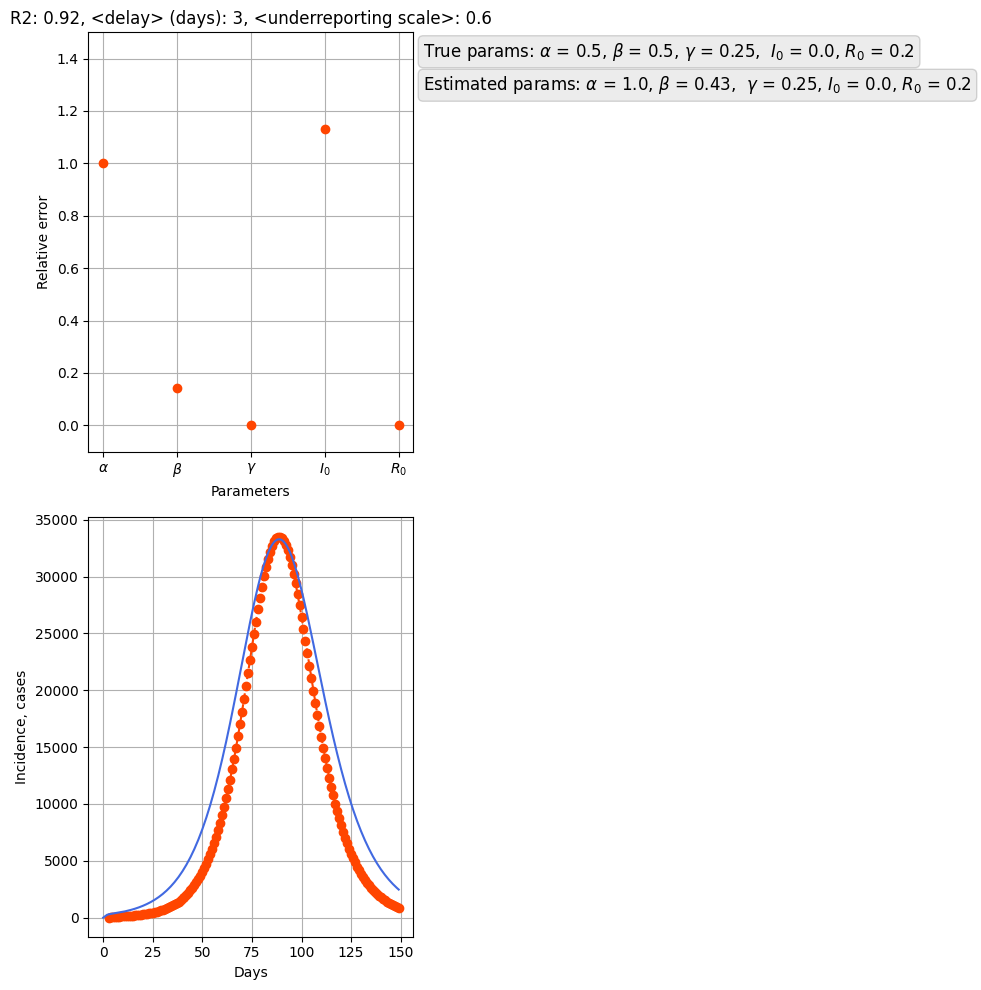

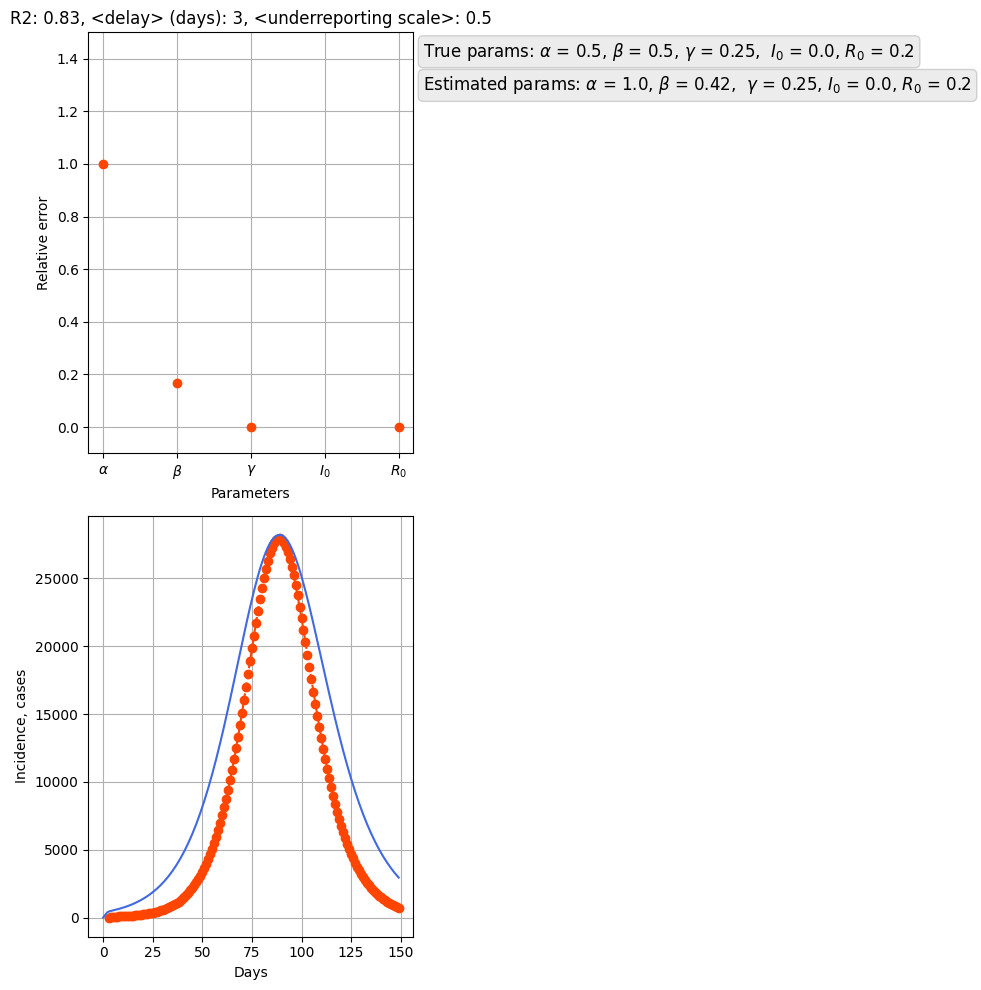

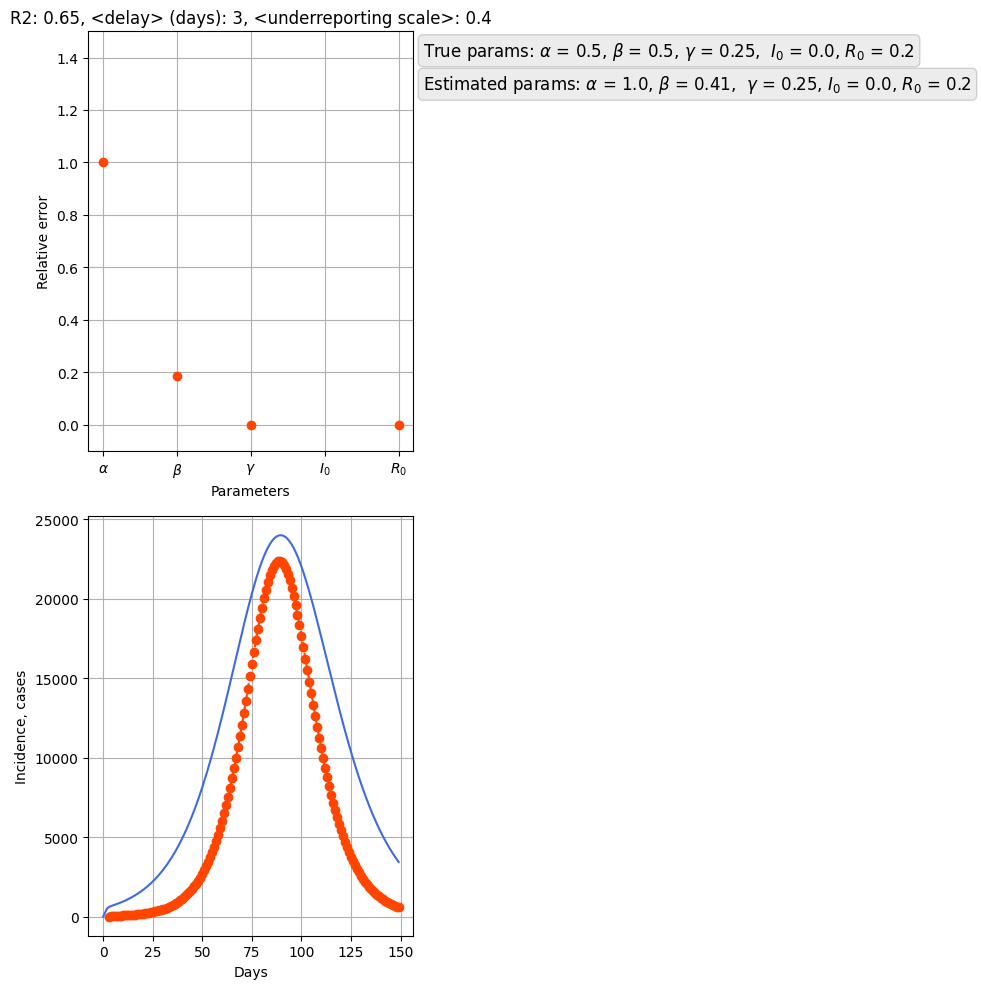

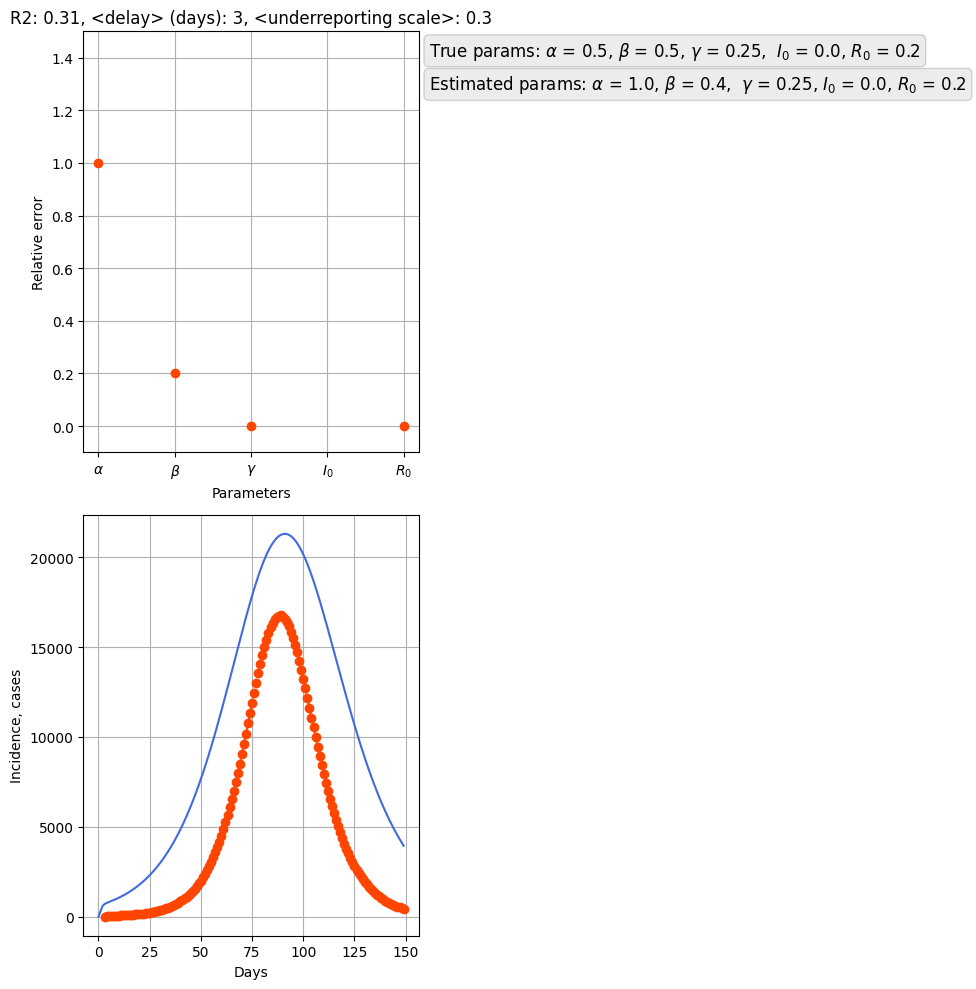

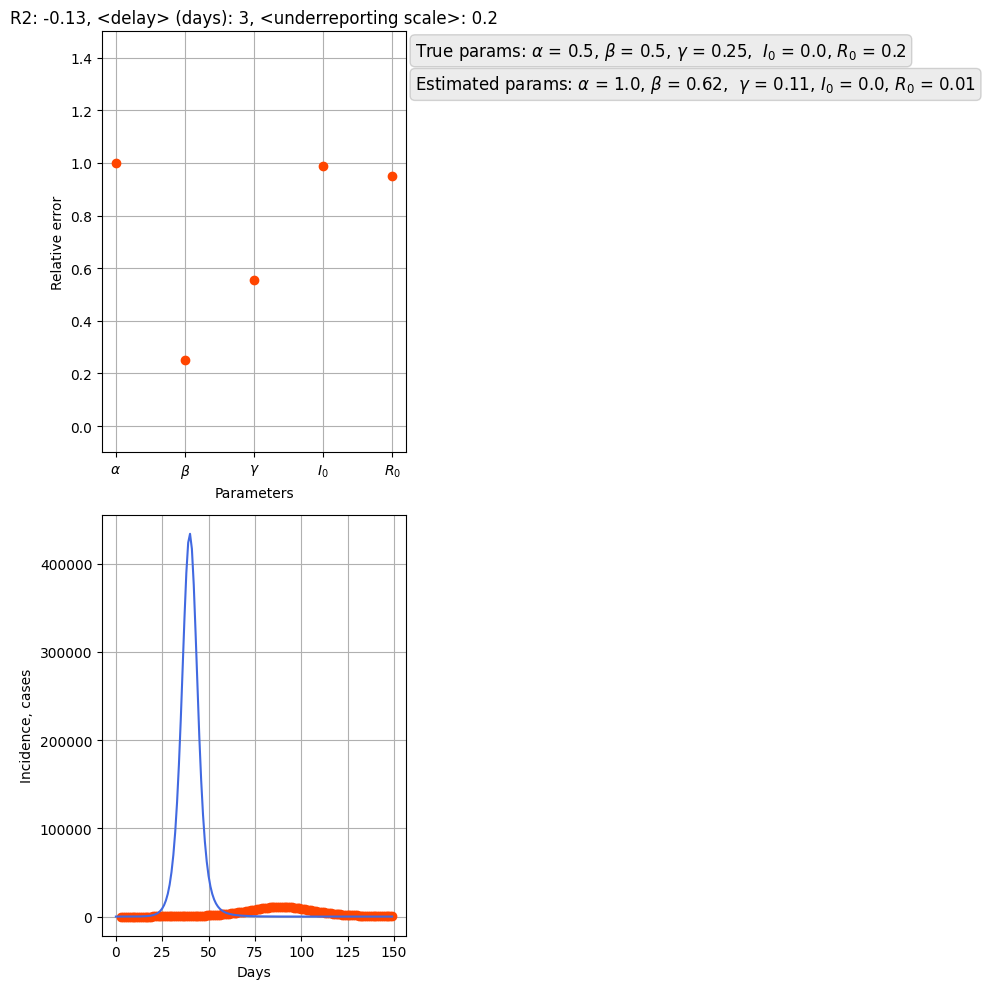

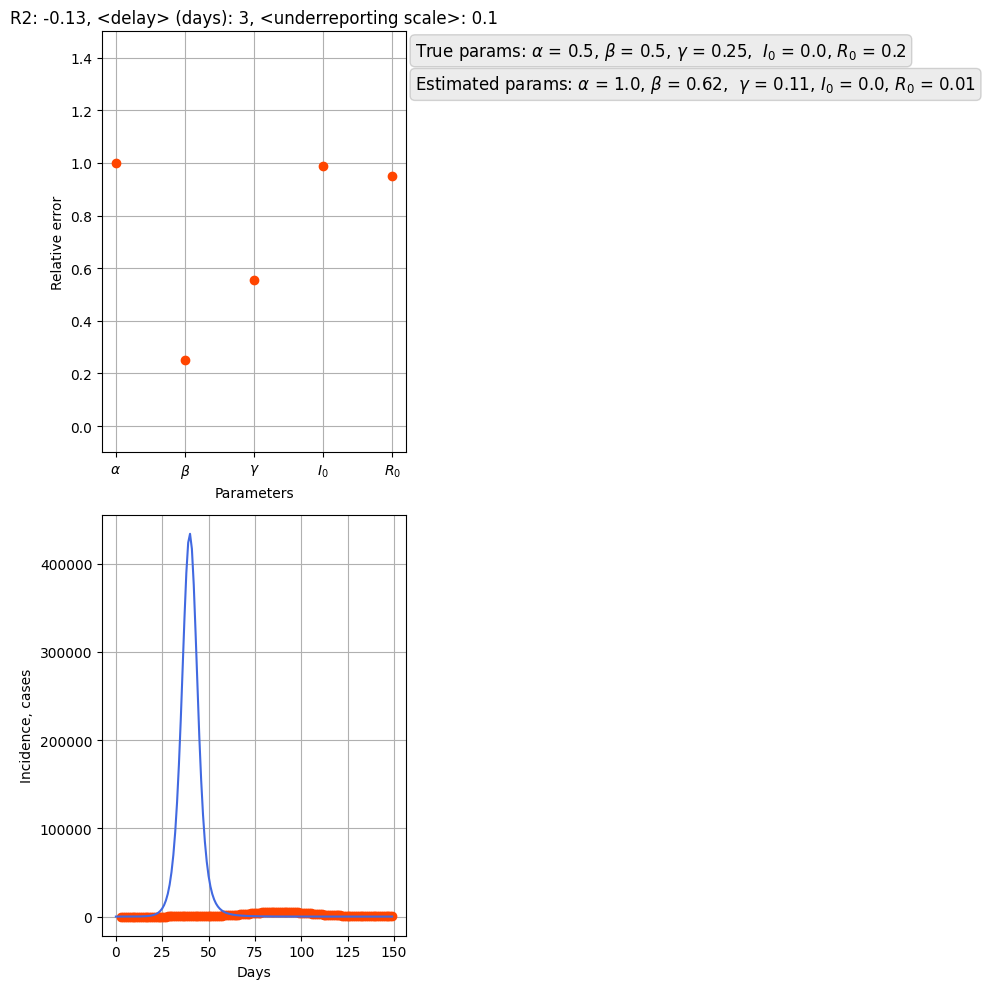

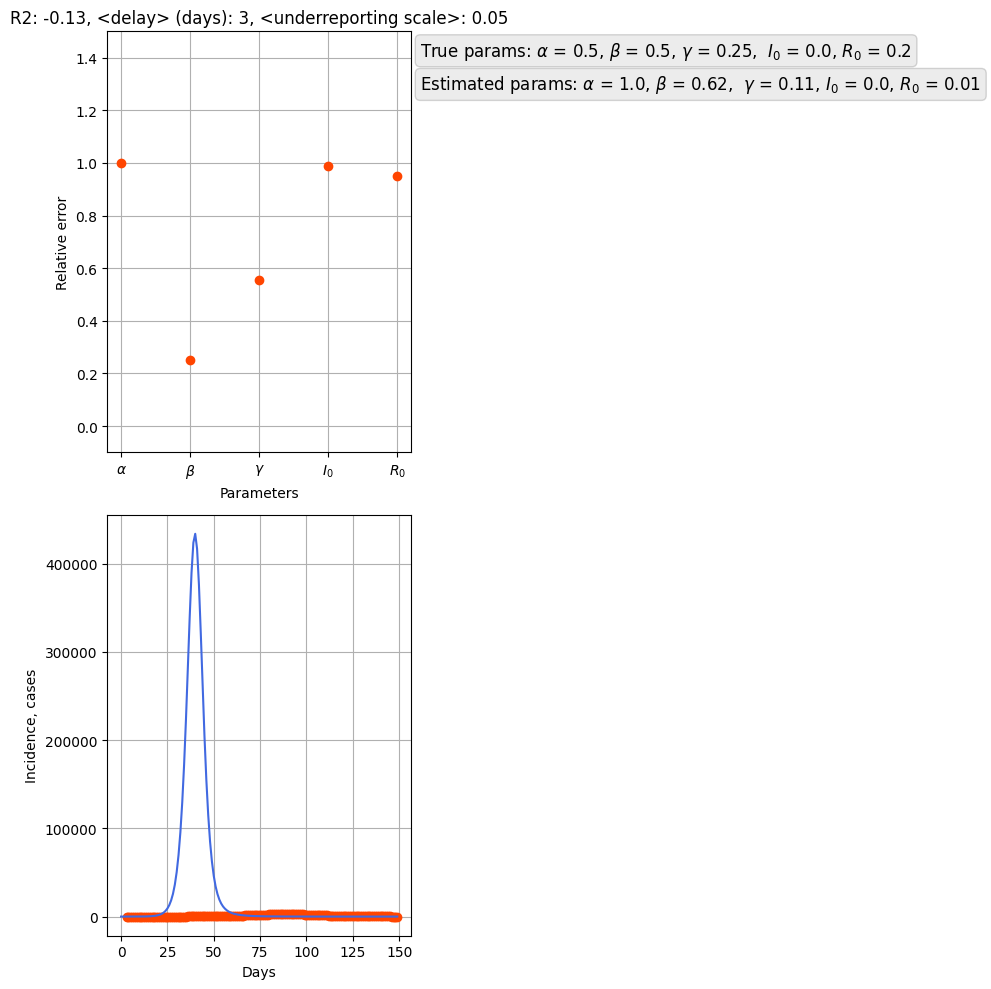

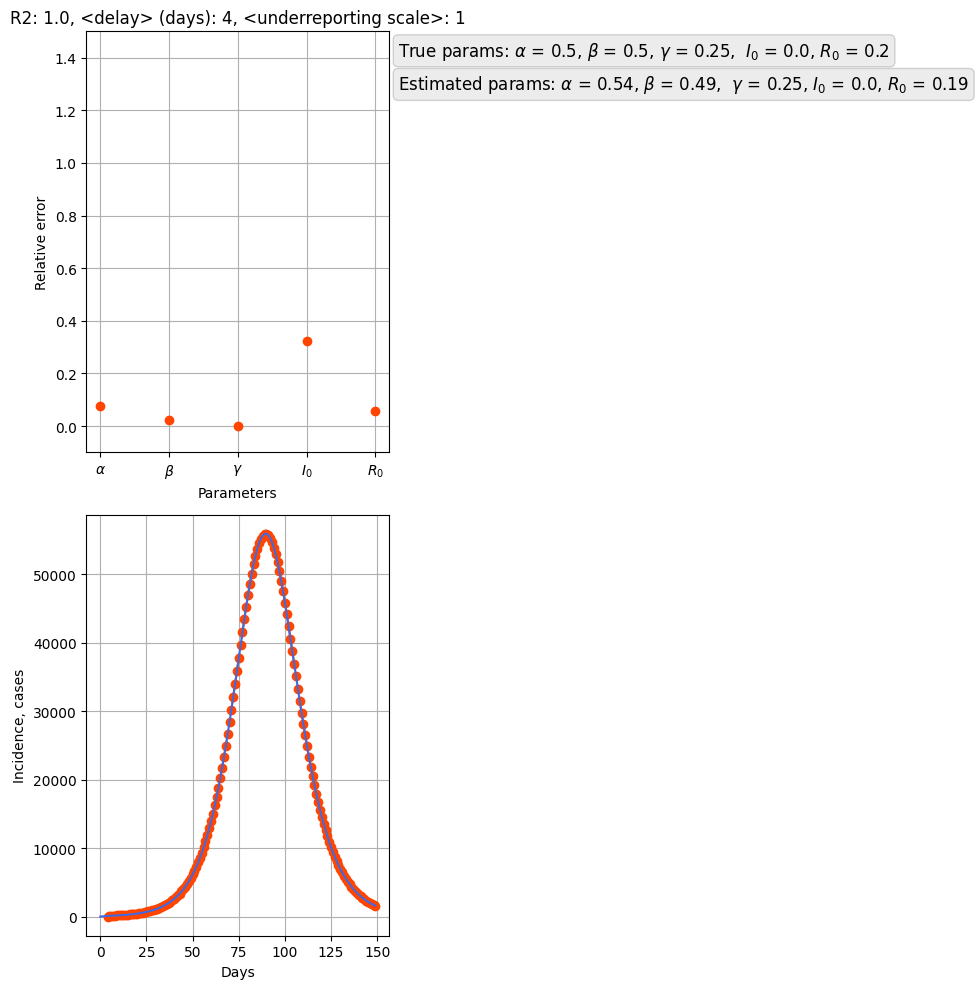

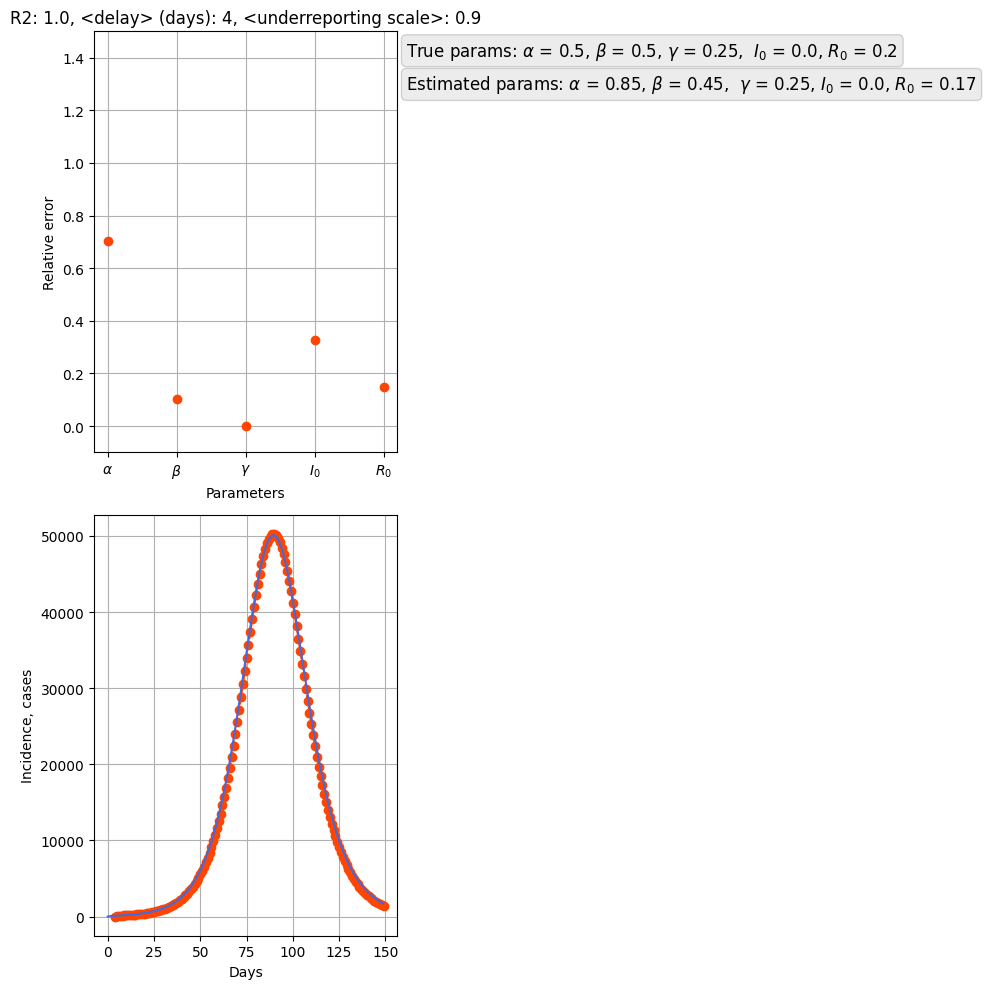

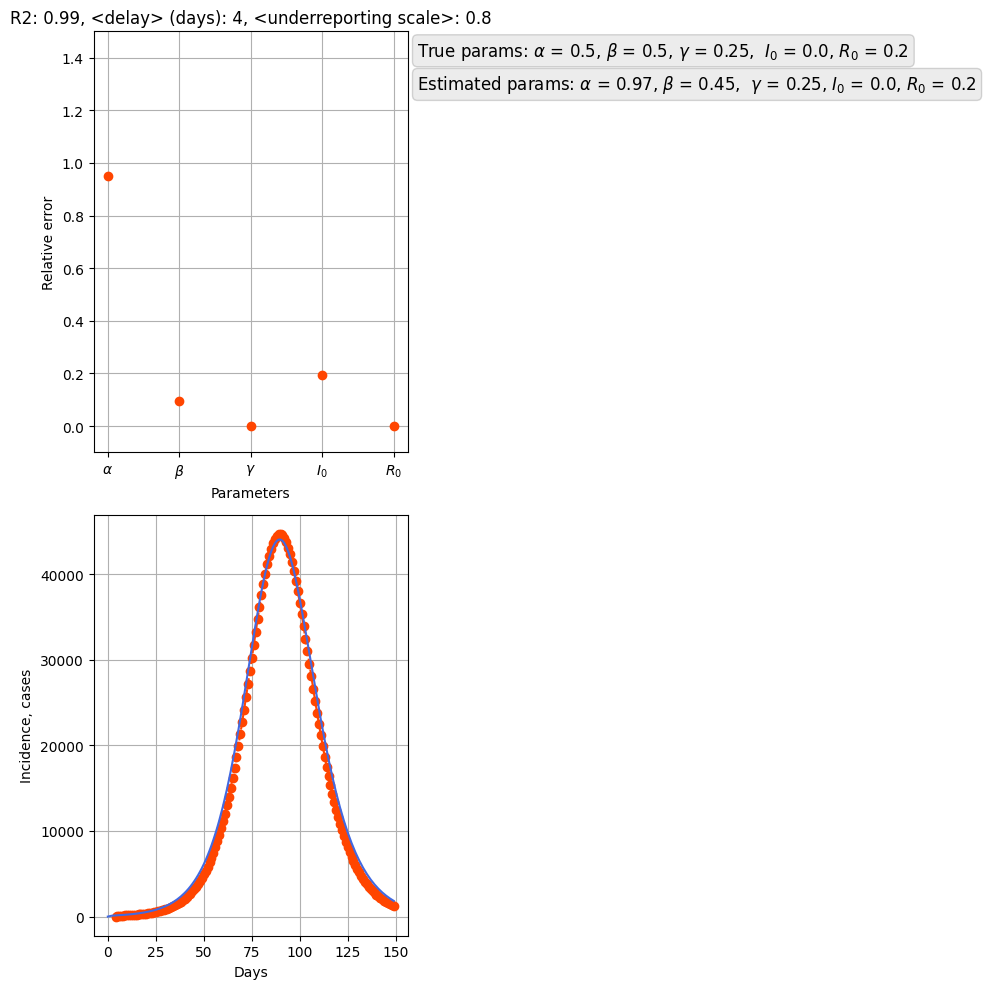

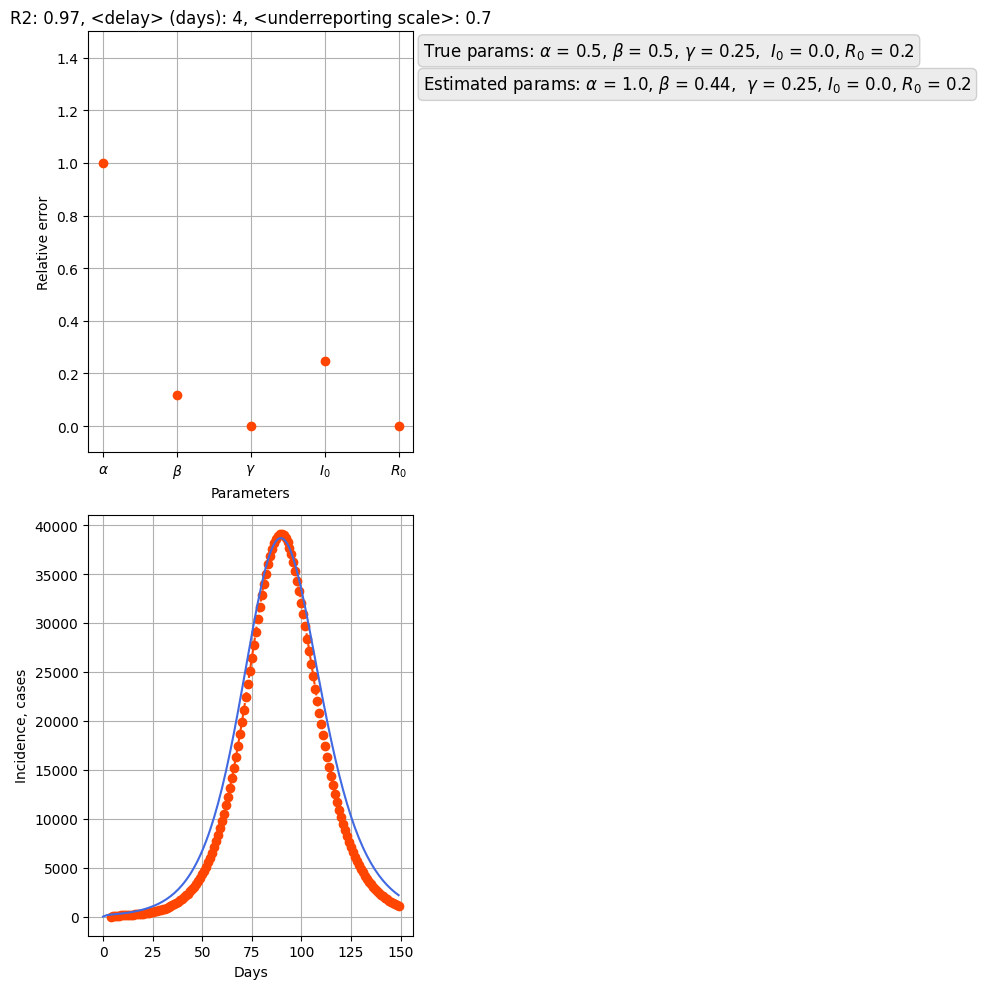

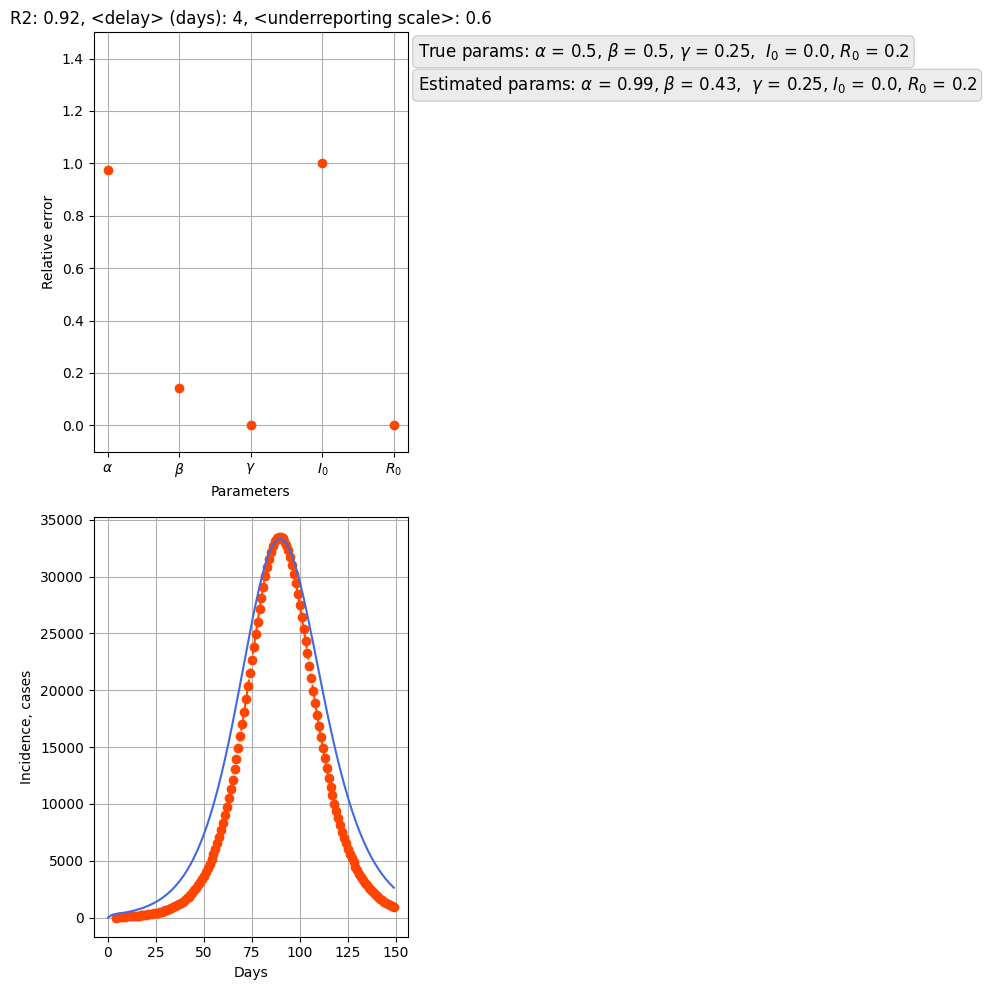

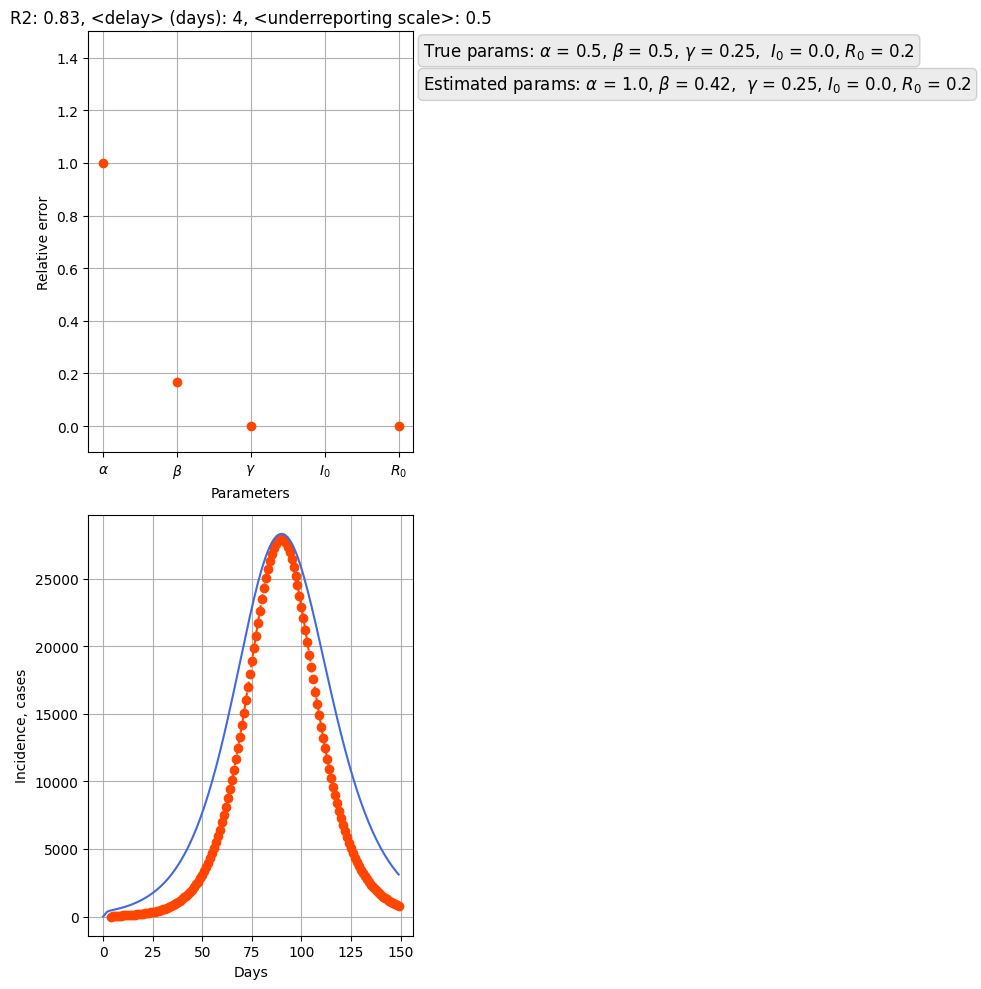

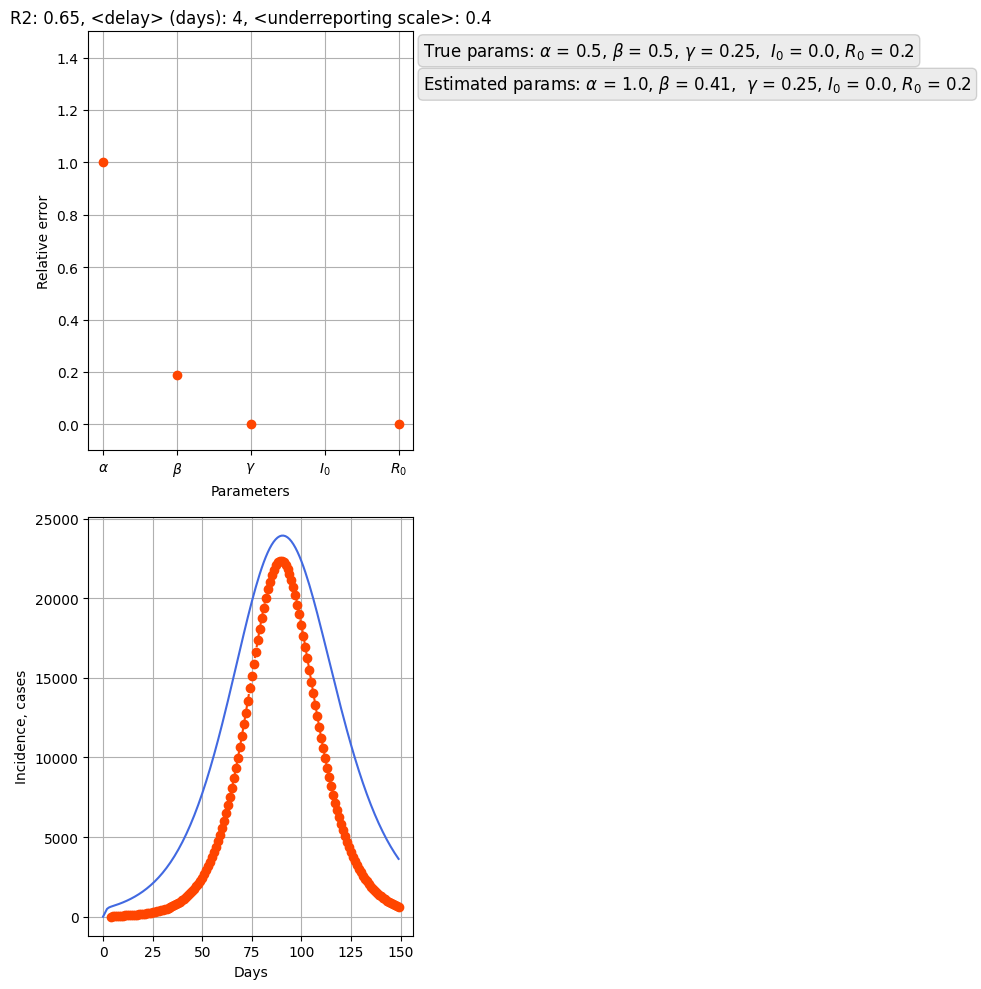

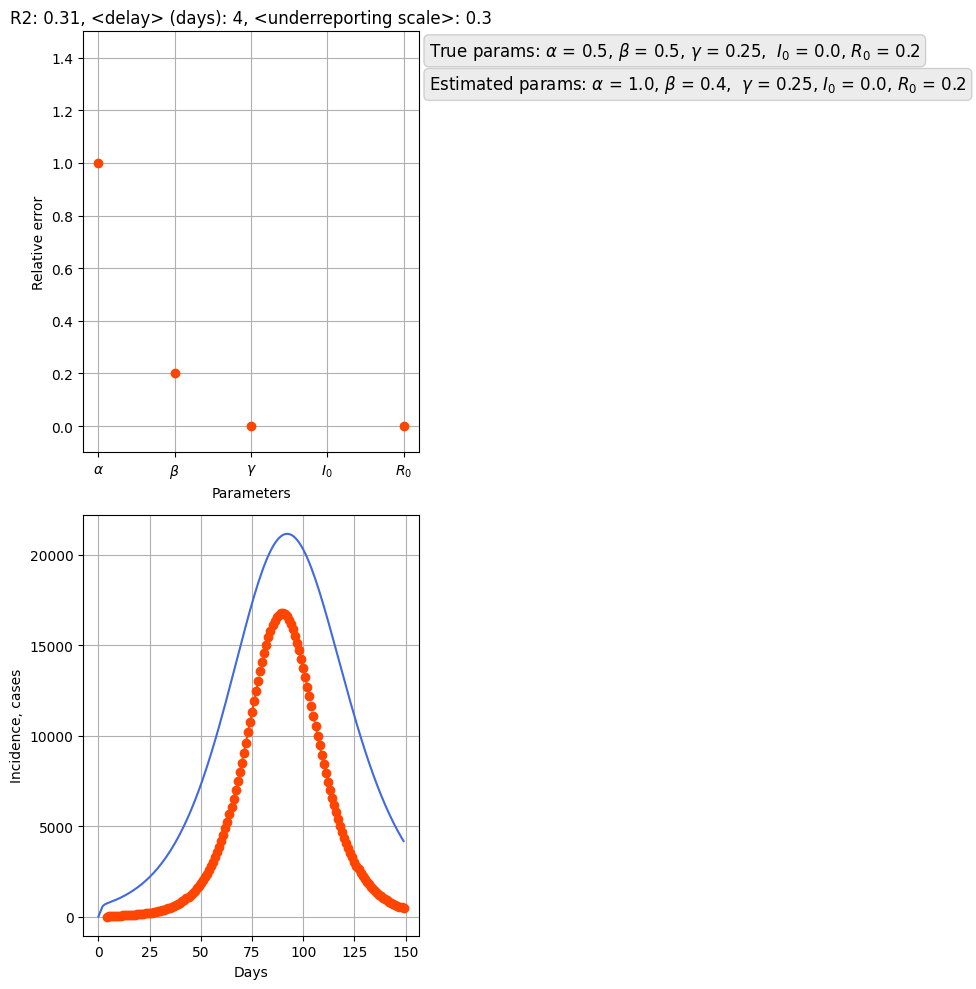

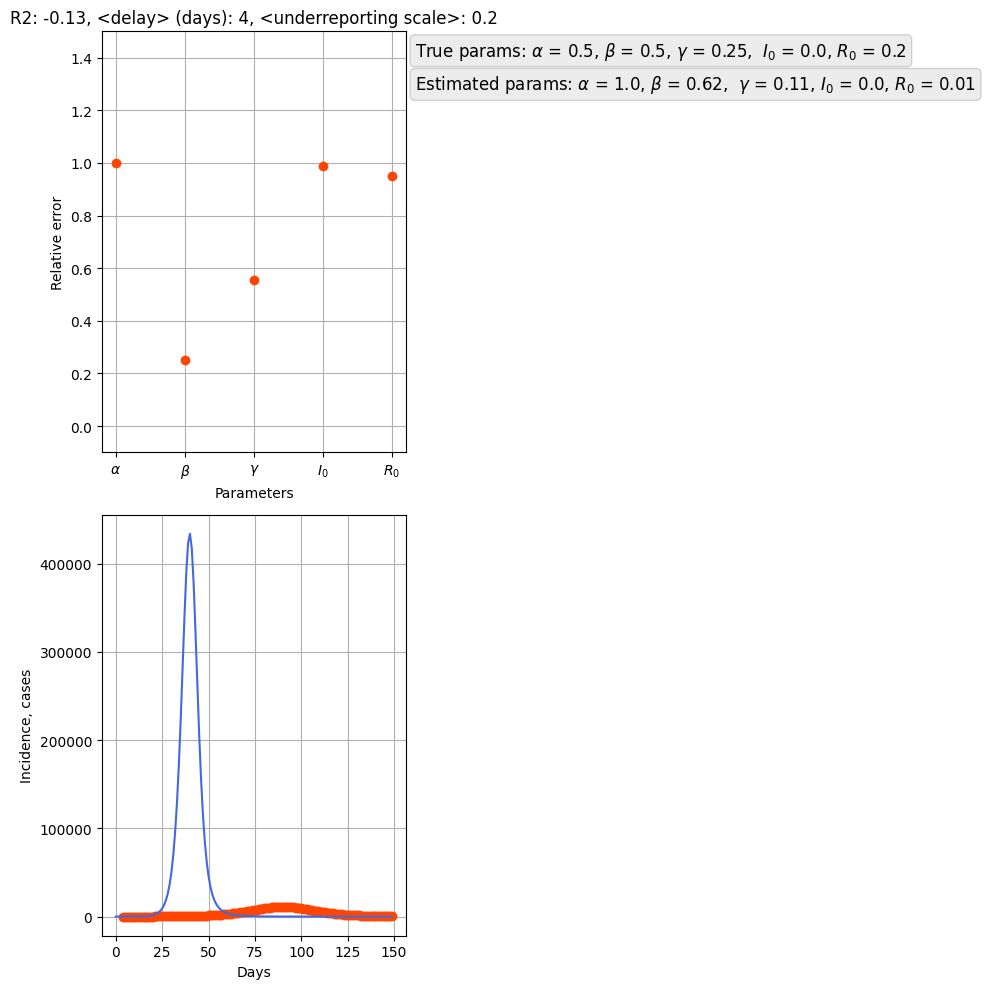

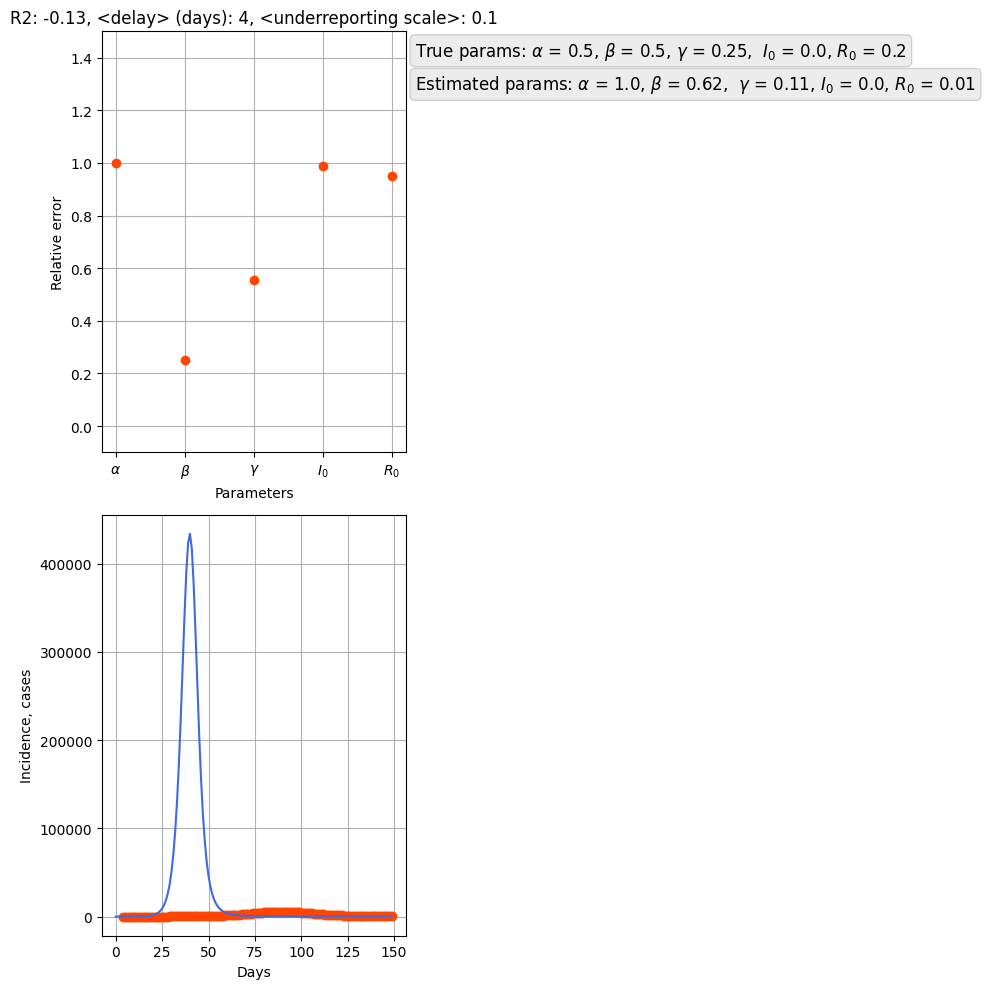

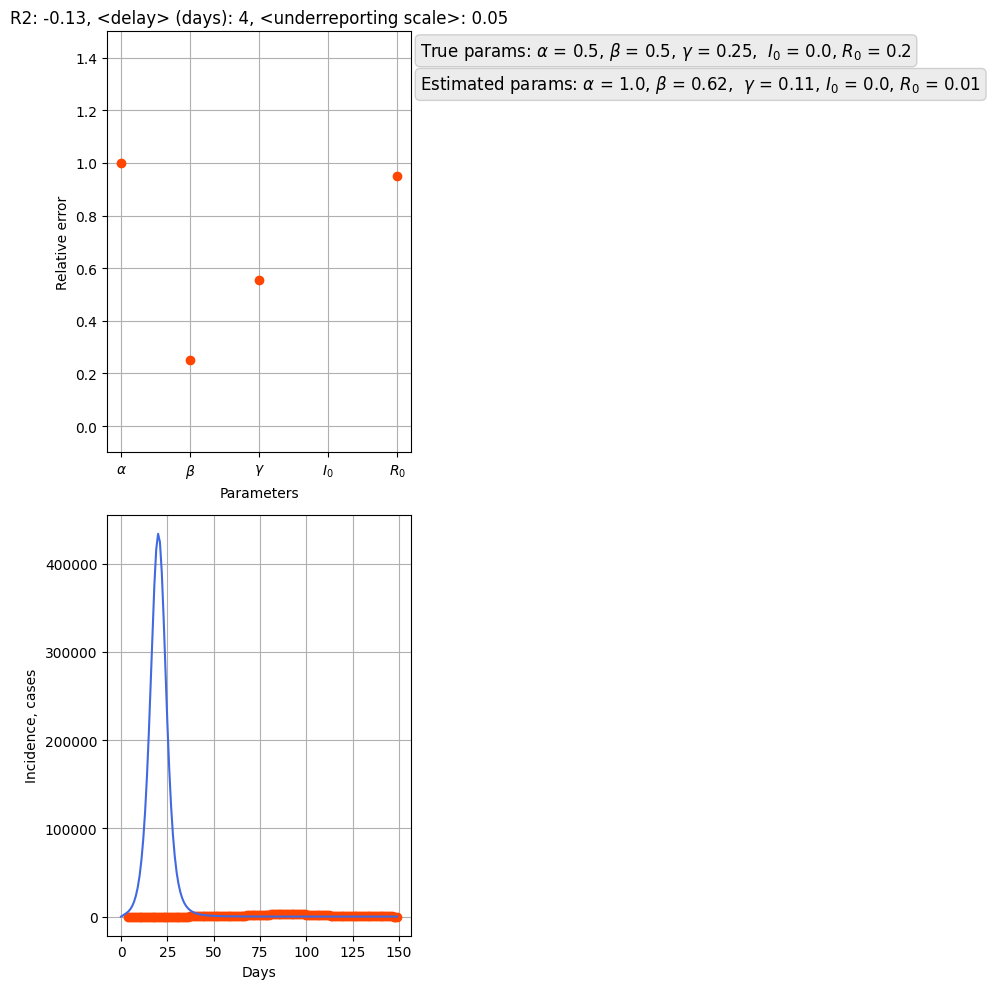

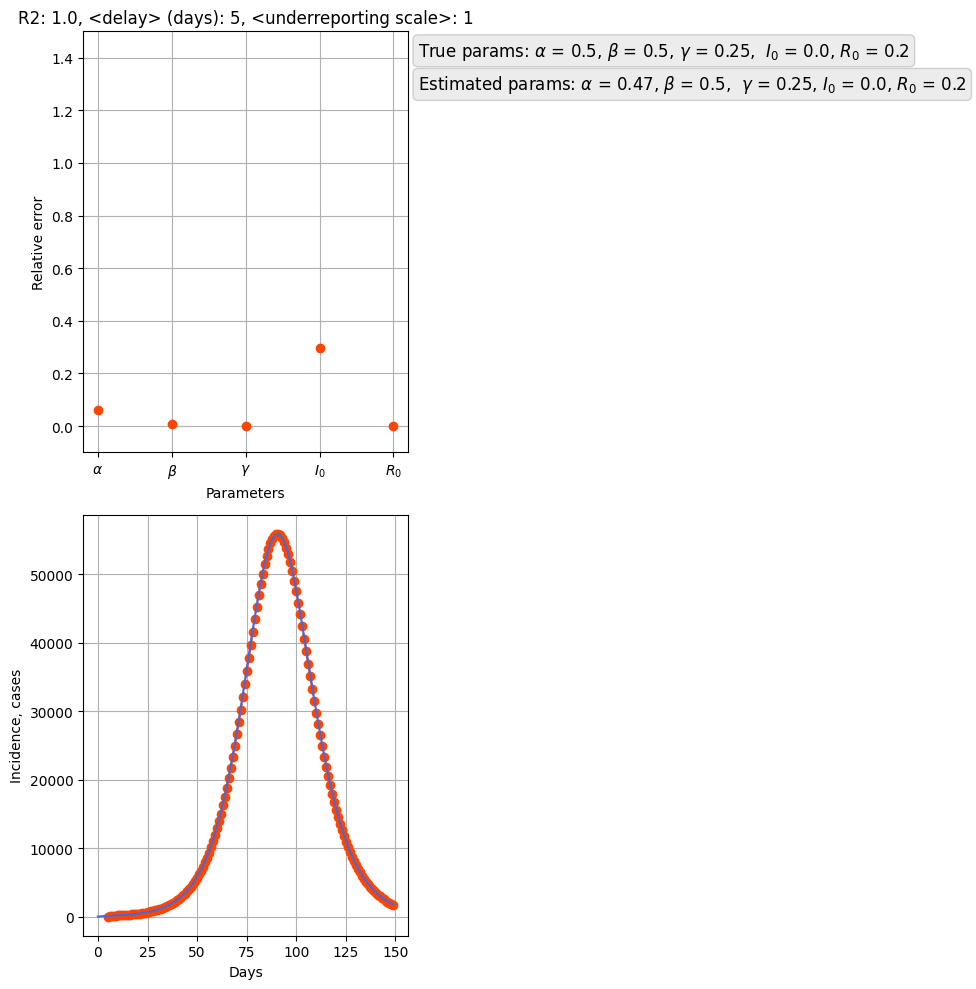

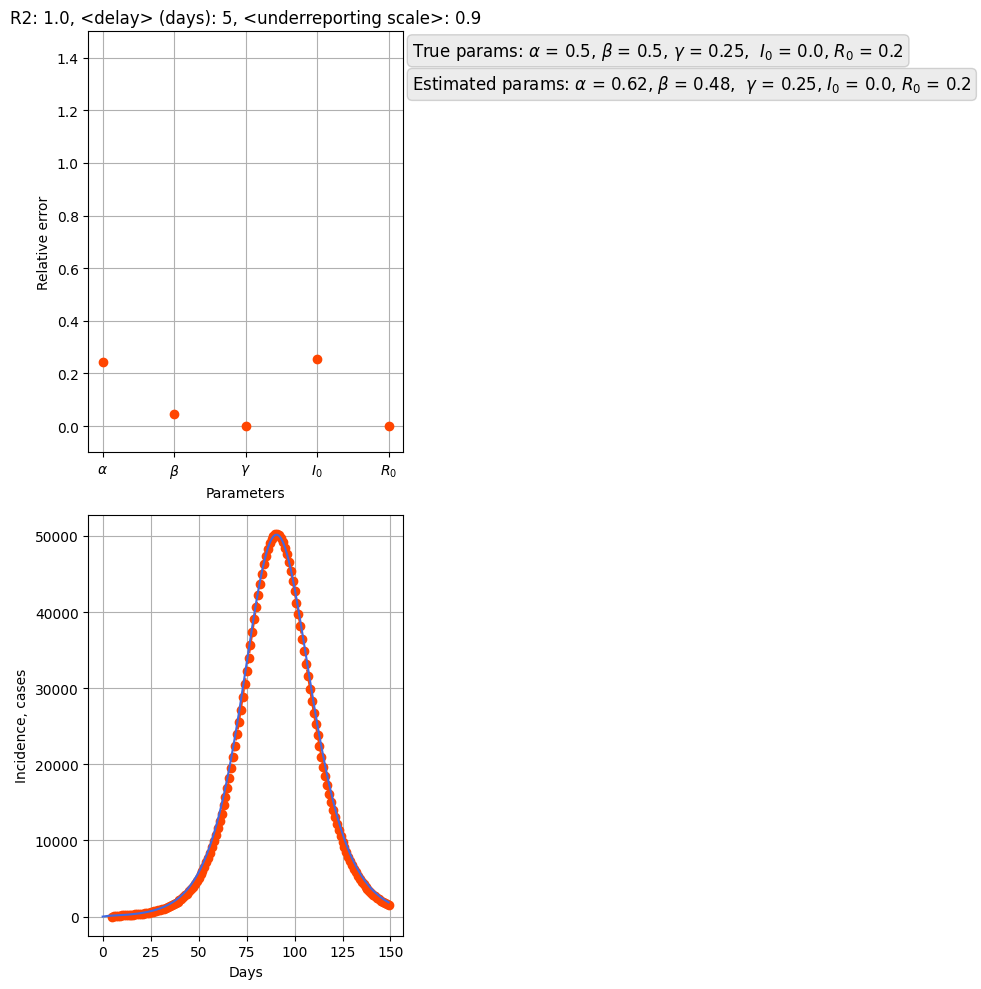

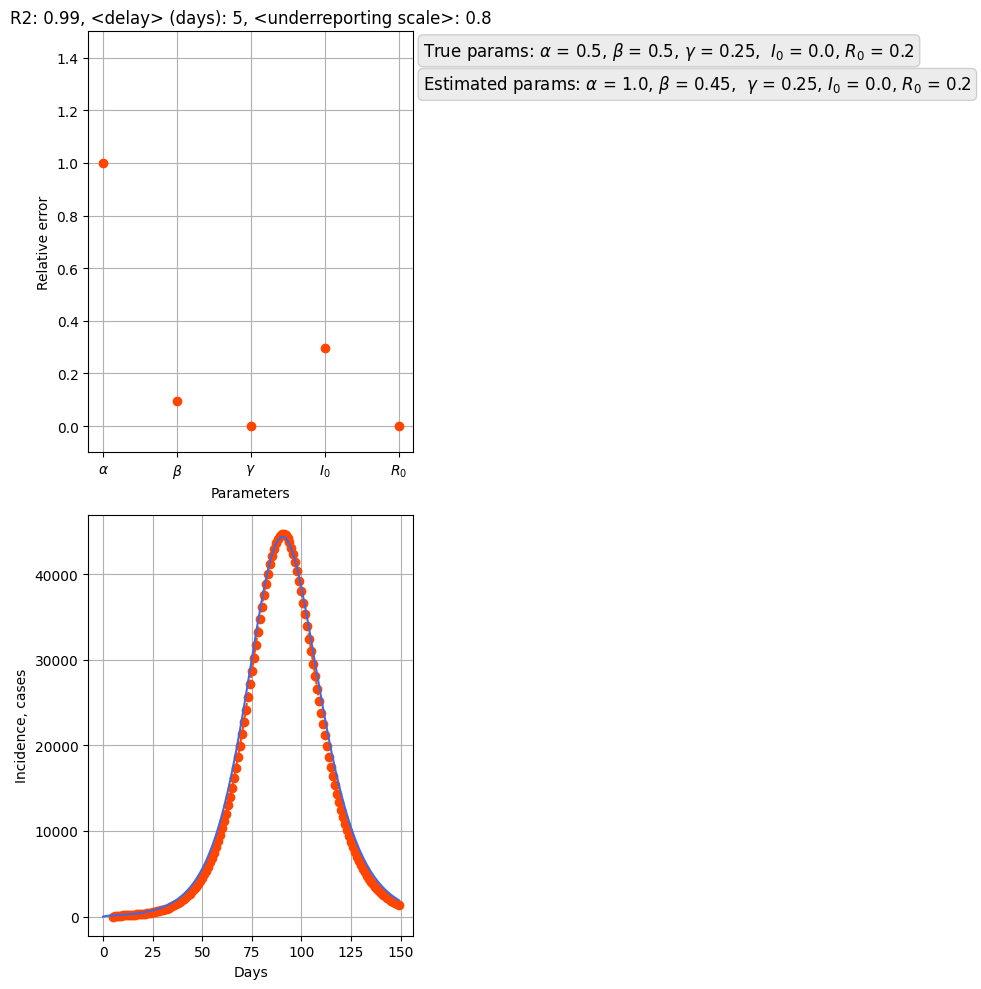

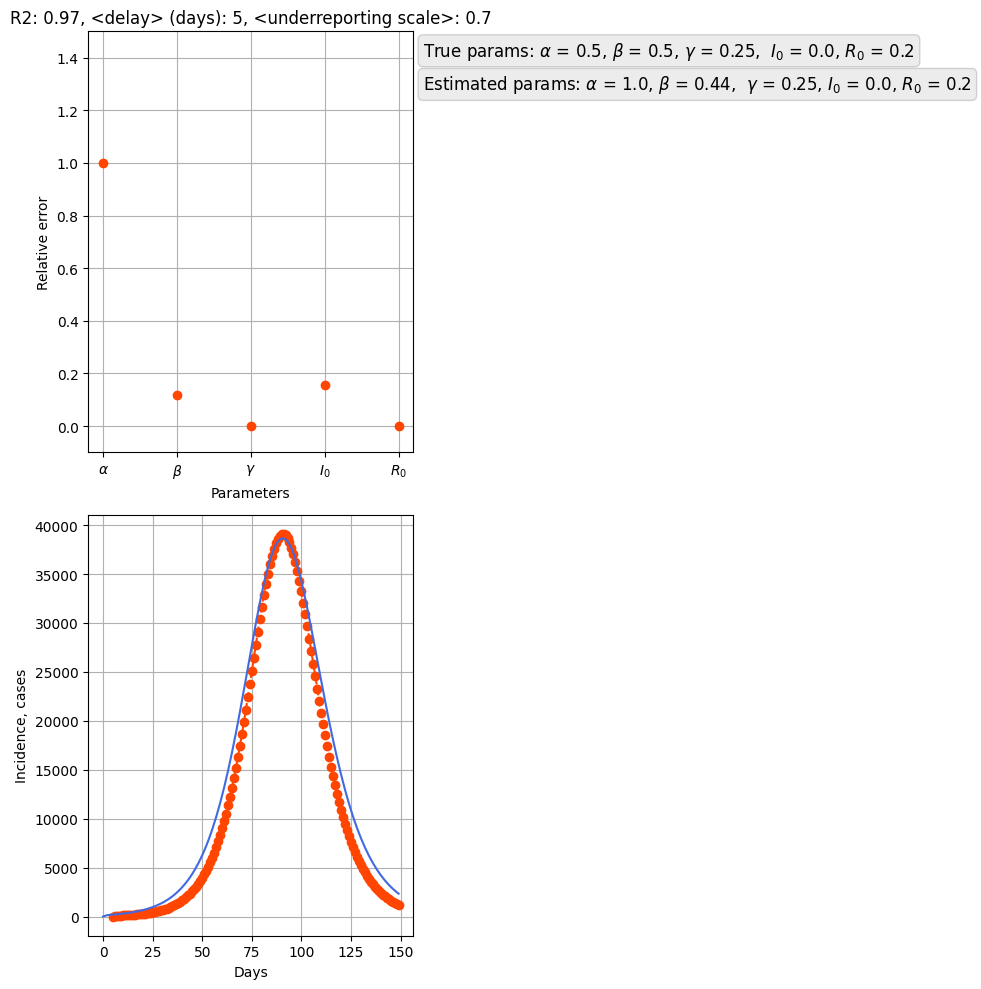

In [59]:
mean_delay_arr = np.arange(0, 13)
mean_underreporting_arr = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
for mean_delay in tqdm.tqdm(mean_delay_arr):
    for mean_underreporting in mean_underreporting_arr:
        model = SEIRModel(population=5*1e6)
        error_model = NaiveErrorModel(res.daily_incidence, mean_delay=mean_delay, 
                                      mean_underreporting=mean_underreporting, error_mode='fixed')
        error_model.add_noise()
        data = error_model.incidence_arr
        estimated_params, r2_estimated = model.calibrate(data)
        fig, ax = plt.subplots(2, 1, figsize=(10, 10))
        ax[0].set_xlabel('Parameters')
        ax[0].set_ylabel('Relative error')
        ax[0].set_title(r'R2: {}, <delay> (days): {}, <underreporting scale>: {}'.format(np.round(r2_estimated, 2), mean_delay, mean_underreporting))
        ax[0].plot(model.calculate_rel_error(true_params, estimated_params), 'o', color='OrangeRed')
        ax[0].set_xticks([0, 1, 2, 3, 4])
        ax[0].set_xticklabels([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$I_0$', r'$R_0$'])
        ax[0].set_ylim([-0.1, 1.5])
        ax[0].grid()
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        ax[0].text(1.03, 0.98, r'True params: $\alpha$ = {}, $\beta$ = {}, $\gamma$ = {},  $I_0$ = {}, $R_0$ = {}'.format(*np.round(true_params.as_list(), 2)),
                transform=ax[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
        ax[0].text(1.03, 0.9, r'Estimated params: $\alpha$ = {}, $\beta$ = {},  $\gamma$ = {}, $I_0$ = {}, $R_0$ = {}'.format(*np.round(estimated_params.as_list(), 2)), 
                transform=ax[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
        
        ax[1].set_xlabel('Days')
        ax[1].set_ylabel('Incidence, cases')
        ax[1].plot(data, '--o', color='OrangeRed', label='True values')
        sim = model.simulate(*estimated_params.as_list(), tmax=150)
        ax[1].plot(sim.daily_incidence, color='RoyalBlue', label='Calibrated curve')
        ax[1].grid()
        ax[1].legend()
        fig.tight_layout()
        fig.savefig('../figures/calibration_{}_{}.png'.format(mean_delay, mean_underreporting))

In [ ]:
mean_underreporting_arr

- Гипотеза, что хорошие данные подчиняются модели из статьи
- Данные, не покрывающиеся такой моделью -- "красная зона"
- Нужно понять, насколько реальные данные отклоняются от модели ошибок
- Восстанавливание исходных эпидкривых (синтетика)
- 
- Восстанавливание исходных эпидкривых (по реальным данным) данные -> I, a, b, p
- 4 вида ошибок: ошибка в данных исходя их стохастичности эпид процесса, 
- позажимать часть ошибок и посмотреть влияние наличия ошибок на способность восстанавливать данные
- 


##### Data restoration: known and defined parameters
$$ m = \frac{a+b}{2}$$
$$I_t = \frac{\mathbb{E}C_t - \frac{m}{p}}{p}$$

In [ ]:
m = 0.07
p = 1/11.8
restored_data = (mean_curve - m/p)/p

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(restored_data, color='ForestGreen', label='Restored data')
ax.plot(res.daily_incidence, color='RoyalBlue', label='Initial data')

ax.set_xlabel('Day')
ax.set_ylabel('Incidence, cases')
ax.legend()
ax.grid()
fig.savefig('restored_data.pdf', bbox_inches='tight')
fig.savefig('restored_data.png', bbox_inches='tight')